In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import libraries
import numpy as np
import torch
import pandas as pd


import copy
import os
import scipy.ndimage

try:
    from skimage import measure, morphology
    from skimage.transform import resize
except:
    print("[INFO] Couldn't find scikit-image... installing it.")
    !pip install scikit-image
    from skimage import measure, morphology
    from skimage.transform import resize

import matplotlib.cm as mpl_color_map
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import ImageGrid

try:
    import cv2
except:
    print("[INFO] Couldn't find Opencv... installing it.")
    !pip install opencv-python
    import cv2

from glob import glob
import re
from collections import defaultdict

try:
    import plotly.express as px
except:
    print("[INFO] Couldn't find plotly... installing it.")
    !pip install plotly
    import plotly.express as px

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Set the manual seeds


try:
    import  lightning.pytorch as L
except:
    !pip install lightning
    import  lightning.pytorch as L


[INFO] Couldn't find torchinfo... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s 

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor,TQDMProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.nn import CrossEntropyLoss
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import LightningModule
from lightning.pytorch import Trainer, seed_everything
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR,LambdaLR,MultiStepLR
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from collections import Counter
from multiprocessing import Pool
import multiprocessing as mp


#render high resolution images
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
csv_dir = "/content/drive/MyDrive/tumor_progression_paper/clinical_info.xlsx"

In [ ]:
data_df= pd.read_excel(csv_dir).iloc[:,1:-3]
data_df.head()

,unique_pt_id,Treatment Course,Lesion #,Lesion Location,mri_type,duration_tx_to_imag (months),Fractions,Lesion Name in NRRD files,Primary Diagnosis,Age at Diagnosis,Gender,Category,Secondary Diagnosis
0,103,1,1,R atrium,stable,13.572133,5,GK.103_1_LR atrium,Serous carcinoma,75,Female,Others,metsovary
1,103,1,2,L Temporal,stable,13.572133,1,GK.103_1_LL temporal,Serous carcinoma,75,Female,Others,metsovary
2,105,1,1,RT Temporal,stable,2.103188,1,GK.105_1_LRT Temporal,Squamous cell carcinoma,58,Male,Others,brainmetskidney
3,114,1,1,Lt Temporal,recurrence,33.453828,1,GK.114_1_LLt Temporal,Invasive ductal carcinoma,60,Female,Breast Cancer,brainmetsbreast
4,115,1,1,Rt Occipital,stable,25.336839,1,GK.115_1_LRt Occipital,Renal cell carcinoma,68,Female,Others,brainmetskidney


In [ ]:
useful_metadata = data_df[["Age at Diagnosis","Gender","duration_tx_to_imag (months)","Secondary Diagnosis","Category"]]

In [ ]:
useful_metadata.head()

,Age at Diagnosis,Gender,duration_tx_to_imag (months),Secondary Diagnosis,Category
0,75,Female,13.572133,metsovary,Others
1,75,Female,13.572133,metsovary,Others
2,58,Male,2.103188,brainmetskidney,Others
3,60,Female,33.453828,brainmetsbreast,Breast Cancer
4,68,Female,25.336839,brainmetskidney,Others


In [ ]:
cat_cols = list(useful_metadata.select_dtypes(include="object").columns)
num_cols = list(set(useful_metadata.columns)-set(cat_cols))
num_cols, cat_cols


(['duration_tx_to_imag (months)', 'Age at Diagnosis'],
 ['Gender', 'Secondary Diagnosis', 'Category'])

In [ ]:
categorical_encoded_df = pd.get_dummies(useful_metadata[cat_cols])
categorical_encoded_df.head()

,Gender_Female,Gender_Male,Secondary Diagnosis_brainmetpostopcavity,Secondary Diagnosis_brainmetsbreast,Secondary Diagnosis_brainmetsendometrialca,Secondary Diagnosis_brainmetsesophageal,Secondary Diagnosis_brainmetskidney,Secondary Diagnosis_brainmetslung,Secondary Diagnosis_brainmetsmelanoma,Secondary Diagnosis_brainmetsovary,Secondary Diagnosis_brainmetsrenalcell,Secondary Diagnosis_brainmetsurothelial,Secondary Diagnosis_brainmetsuterine,Secondary Diagnosis_breastwithlargefrontalmet,Secondary Diagnosis_gkbrainmets2lesions,Secondary Diagnosis_metsovary,Secondary Diagnosis_rccbrainmets,Category_Breast Cancer,Category_Lung Cancer,Category_Others
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
numerical_df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(useful_metadata[num_cols]), columns=num_cols)

In [ ]:
dataset_df = pd.concat([data_df[["unique_pt_id","Treatment Course","Lesion #","Lesion Location","mri_type","Gender"]],numerical_df_scaled,categorical_encoded_df], axis=1)
dataset_df.head()

,unique_pt_id,Treatment Course,Lesion #,Lesion Location,mri_type,Gender,duration_tx_to_imag (months),Age at Diagnosis,Gender_Female,Gender_Male,...,Secondary Diagnosis_brainmetsrenalcell,Secondary Diagnosis_brainmetsurothelial,Secondary Diagnosis_brainmetsuterine,Secondary Diagnosis_breastwithlargefrontalmet,Secondary Diagnosis_gkbrainmets2lesions,Secondary Diagnosis_metsovary,Secondary Diagnosis_rccbrainmets,Category_Breast Cancer,Category_Lung Cancer,Category_Others
0,103,1,1,R atrium,stable,Female,0.239036,0.962963,1,0,...,0,0,0,0,0,1,0,0,0,1
1,103,1,2,L Temporal,stable,Female,0.239036,0.962963,1,0,...,0,0,0,0,0,1,0,0,0,1
2,105,1,1,RT Temporal,stable,Male,0.023471,0.648148,0,1,...,0,0,0,0,0,0,0,0,0,1
3,114,1,1,Lt Temporal,recurrence,Female,0.612724,0.685185,1,0,...,0,0,0,0,0,0,0,1,0,0
4,115,1,1,Rt Occipital,stable,Female,0.460161,0.833333,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
dataset_df.shape

(239, 28)

In [ ]:
arr_dir = "/content/drive/MyDrive/tumor_progression_paper/MRI_Dose_ROI_Array_Dataset"
#load MRI
ROI_MRI = np.load(f"{arr_dir}/img_arr_updated.npy")

In [ ]:
#load dosage
ROI_Dosage = np.load(f"{arr_dir}/dosage_arr_updated.npy")

In [ ]:
import math
def display_image(img_arr, num_img=None):
    num_slices =img_arr.shape[2]
    if num_img:
        num_slices=num_img
    ncols = 6
    if num_slices > ncols:
        nrows = math.ceil(num_slices/ncols)
    else:
        nrows=1
        ncols=num_slices
    fig, axes = plt.subplots(nrows,ncols,figsize=(10,8))
    if num_slices>1:
        axes = axes.flatten()
        for i in range(num_slices):
            axes[i].imshow(img_arr[:,:,i])
            axes[i].axis("off")
    else:
        plt.imshow(img_arr.squeeze(),)
            #print(i)
        #plt.show()

Location:R atrium; Label:stable 


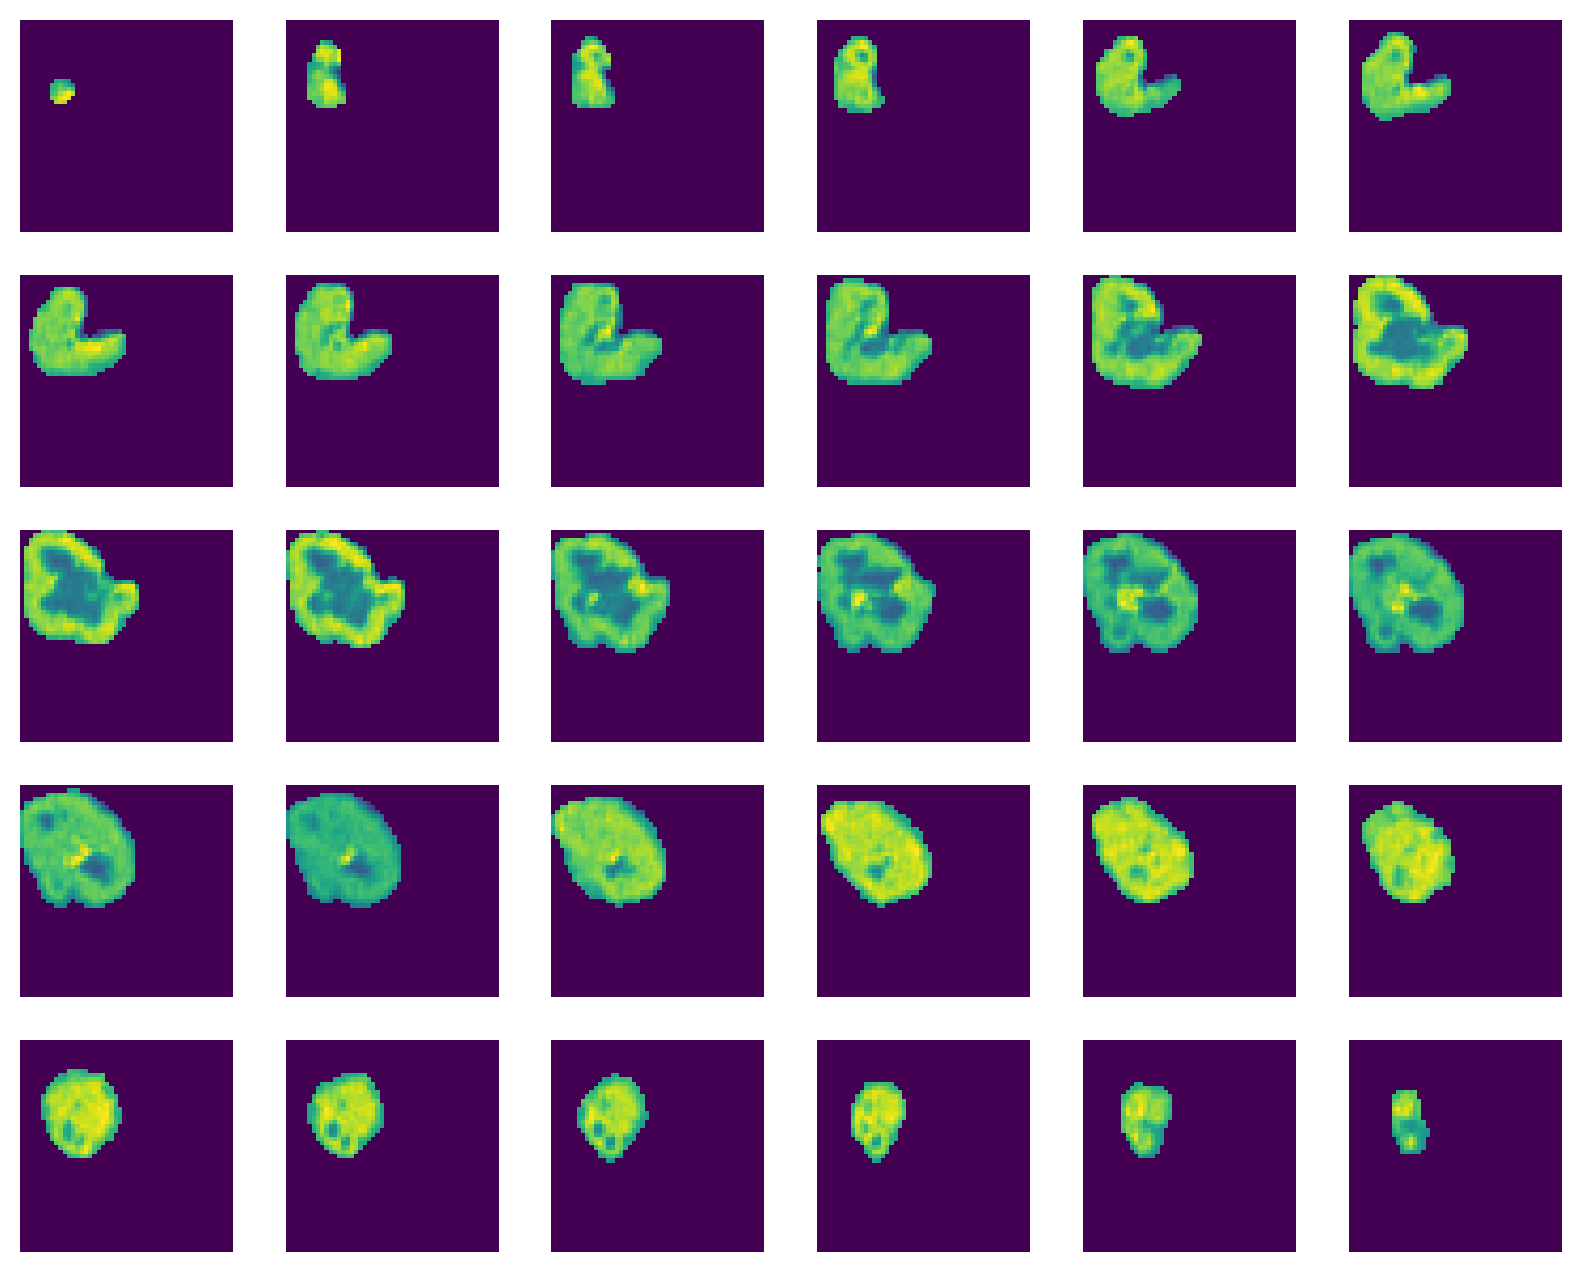

In [ ]:
img_indx = 0

display_image(ROI_MRI[img_indx], num_img=30)
print(f'Location:{dataset_df.iloc[img_indx]["Lesion Location"]}; Label:{dataset_df.iloc[img_indx]["mri_type"]} ')

**Display RTDOSE Slices**

Location:R atrium; Label:stable 


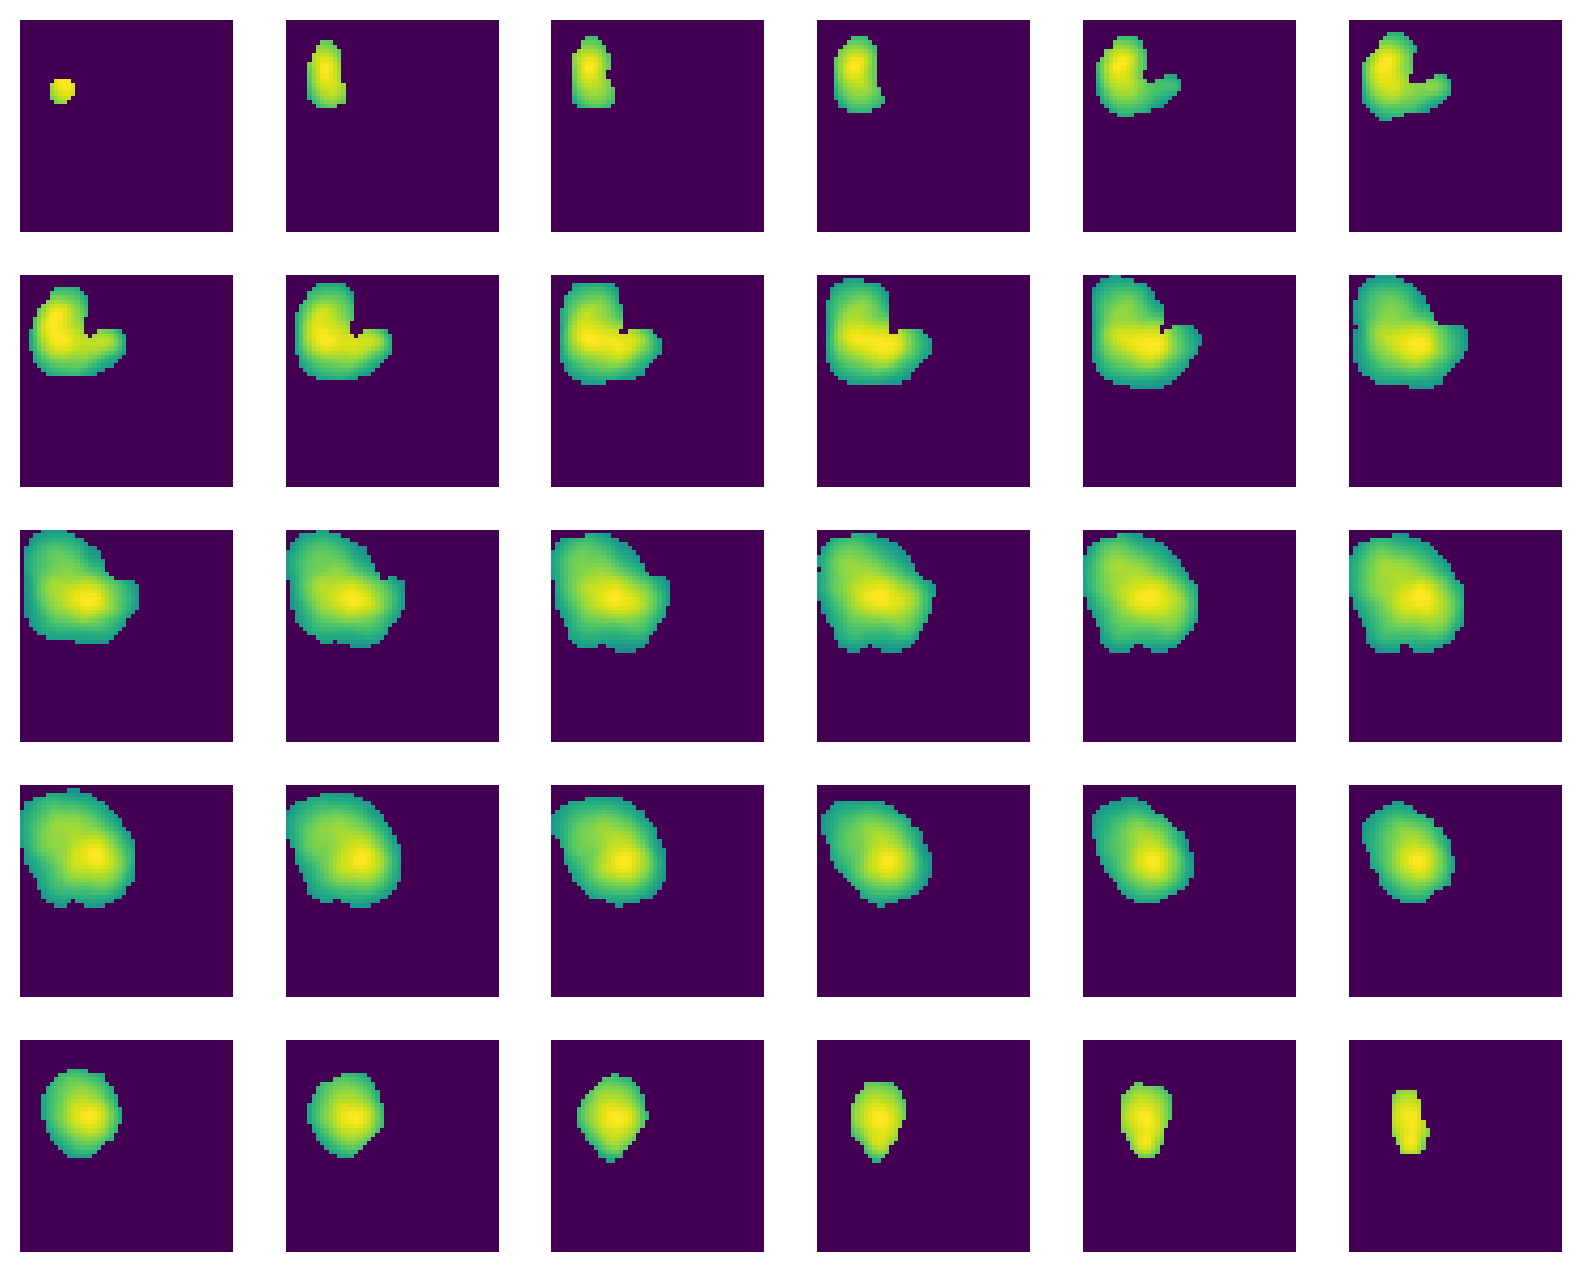

In [ ]:
display_image(ROI_Dosage[img_indx], num_img=30)
print(f'Location:{dataset_df.iloc[img_indx]["Lesion Location"]}; Label:{dataset_df.iloc[img_indx]["mri_type"]} ')

In [ ]:
ROI_MRI.shape, ROI_Dosage.shape

((239, 50, 50, 50), (239, 50, 50, 50))

In [ ]:
radiomics_metadata = pd.read_excel("/content/drive/MyDrive/tumor_progression_paper/radiomics_metadata.xlsx").iloc[:,1:]
radiomics_metadata.shape

(231, 11)

In [ ]:
radiomics_metadata.head()

,patient_id,course_num,lesion_location,lesion_num,duration_tx_to_imag (months),Fractions,mri_type,Primary Diagnosis,Age at Diagnosis,Gender,Secondary Diagnosis
0,103,1,r atrium,1,13.572133,5,0,Serous carcinoma,75,Female,metsovary
1,103,1,l temporal,2,13.572133,1,0,Serous carcinoma,75,Female,metsovary
2,105,1,rt temporal,1,2.103188,1,0,Squamous cell carcinoma,58,Male,brainmetskidney
3,114,1,lt temporal,1,33.453828,1,1,Invasive ductal carcinoma,60,Female,brainmetsbreast
4,115,1,rt occipital,1,25.336839,1,0,Renal cell carcinoma,68,Female,brainmetskidney


## Using Dataset B : Multiple tumors from the same image must be in the same data split ##

**Create Training, Validation, and Testing Split --- 70-15-15**

In [ ]:
# np.random.randint(0,1000)

In [ ]:
from sklearn.model_selection import train_test_split
seed =0#np.random.randint(0,50)
seed_everything(seed, workers=True)

#reproducibility
np.random.seed(seed)
#torch.manual_seed(seed)

if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)


INFO: Global seed set to 0
INFO:lightning.fabric.utilities.seed:Global seed set to 0


In [ ]:
# from random import Random
# subject_ids = list(radiomics_metadata.patient_id.unique())
# Random(seed).shuffle(subject_ids)  #split3, 8,9,11,18

In [ ]:
# test_ids =  subject_ids[round(0.85*len(subject_ids)):]
# valid_ids = subject_ids[round(0.7*len(subject_ids)): round(0.85*len(subject_ids))]
# train_ids = list(set(dataset_df.unique_pt_id.unique())-set(test_ids)-set(valid_ids))

In [ ]:
# train_data = dataset_df[dataset_df.unique_pt_id.isin(train_ids)]
# validation_data = dataset_df[dataset_df.unique_pt_id.isin(valid_ids)]
# test_data = dataset_df[dataset_df.unique_pt_id.isin(test_ids)]

In [ ]:
# len(train_ids),len(valid_ids),len(test_ids)

In [ ]:
# len(train_data), len(validation_data), len(test_data)

In [ ]:
# train_data.mri_type.value_counts()

In [ ]:
# validation_data.mri_type.value_counts()

In [ ]:
# test_data.mri_type.value_counts()

## using Data Split A ##

To ensure that we evaluate based on the same samples we used for radiomics, we first use the radiomics test set to select the corresponding test set here

In [ ]:
#Create training and testing split --80/20
#training_data, test_data = train_test_split(dataset_df, test_size=0.2, stratify=data_df[["mri_type","Gender"]], random_state=seed)
_,test_temp = train_test_split(radiomics_metadata, test_size=0.2, stratify=radiomics_metadata[["mri_type","Gender"]], random_state=seed)
test_df = dataset_df.merge(test_temp, left_on=["unique_pt_id","Treatment Course","Lesion #"],
                 right_on=["patient_id","course_num","lesion_num"], how="inner")
test_data =  dataset_df.loc[test_df.index]
training_data= dataset_df.loc[~dataset_df.index.isin(test_data.index)]

#From the training split ---create train and valudation dataset 80/20
train_data, validation_data = train_test_split(training_data, test_size=0.25, stratify=training_data[["mri_type","Gender"]], random_state=seed)

In [ ]:
train_data.shape, validation_data.shape, test_data.shape

((144, 28), (49, 28), (46, 28))

In [ ]:
train_data.mri_type.value_counts()

stable        131
recurrence     13
Name: mri_type, dtype: int64

In [ ]:
validation_data.mri_type.value_counts()

stable        45
recurrence     4
Name: mri_type, dtype: int64

In [ ]:
test_data.mri_type.value_counts()

stable        40
recurrence     6
Name: mri_type, dtype: int64

**Get the MRI and DOSAGE ARR for the train, Val and Test set**

**Train**

In [ ]:
MRI_ARR_train = ROI_MRI[np.array(train_data.index)]
DOSAGE_ARR_train = ROI_Dosage[np.array(train_data.index)]
MRI_ARR_train.shape,DOSAGE_ARR_train.shape

((144, 50, 50, 50), (144, 50, 50, 50))

**Validation**

In [ ]:
MRI_ARR_val = ROI_MRI[np.array(validation_data.index)]
DOSAGE_ARR_val = ROI_Dosage[np.array(validation_data.index)]
MRI_ARR_val.shape,DOSAGE_ARR_val.shape

((49, 50, 50, 50), (49, 50, 50, 50))

**Test**

In [ ]:
MRI_ARR_test = ROI_MRI[np.array(test_data.index)]
DOSAGE_ARR_test = ROI_Dosage[np.array(test_data.index)]
MRI_ARR_test.shape,DOSAGE_ARR_test.shape

((46, 50, 50, 50), (46, 50, 50, 50))

In [ ]:
train_data=train_data.reset_index(drop=True)
validation_data=validation_data.reset_index(drop=True)
test_data=test_data.reset_index(drop=True)

In [ ]:
train_data.shape, validation_data.shape, test_data.shape

((144, 28), (49, 28), (46, 28))

In [ ]:
train_data.head()

,unique_pt_id,Treatment Course,Lesion #,Lesion Location,mri_type,Gender,duration_tx_to_imag (months),Age at Diagnosis,Gender_Female,Gender_Male,...,Secondary Diagnosis_brainmetsrenalcell,Secondary Diagnosis_brainmetsurothelial,Secondary Diagnosis_brainmetsuterine,Secondary Diagnosis_breastwithlargefrontalmet,Secondary Diagnosis_gkbrainmets2lesions,Secondary Diagnosis_metsovary,Secondary Diagnosis_rccbrainmets,Category_Breast Cancer,Category_Lung Cancer,Category_Others
0,152,3,22,Rt Ant Front 1,stable,Male,0.004941,0.240741,0,1,...,0,0,0,0,0,0,0,0,0,1
1,274,1,2,Lt Parietal,stable,Female,0.531192,0.685185,1,0,...,0,0,0,0,0,0,0,1,0,0
2,257,3,16,Lt Post Cerebe,stable,Female,0.760346,0.648148,1,0,...,1,0,0,0,0,0,0,0,0,1
3,243,2,14,Lt med ant Fro,stable,Female,0.161211,0.481481,1,0,...,0,0,0,0,0,0,0,1,0,0
4,467,1,14,Rt Ant Lat Ven,stable,Male,0.047560,0.759259,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
train_data.loc[0,"duration_tx_to_imag (months)":].values.shape

(22,)

In [ ]:
# validation_data, test_data = test_data , validation_data
# validation_data.mri_type.value_counts()

**Define Torch Dataset**

In [ ]:
import os
import pathlib
import torch, torchvision
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
class ImageFolder(Dataset):

    def __init__(self, df, MRI_ARR, DOSAGE_ARR) -> None:
        self.data = df.copy()
        self.MRI_ARR = MRI_ARR
        self.DOSAGE_ARR = DOSAGE_ARR
        self.label2index= {"recurrence":1,"stable":0}

    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        mri_3d = self.MRI_ARR[index]
        rtdose_3d = self.DOSAGE_ARR[index]
        lesion_location = self.data.iloc[index]["Lesion Location"]
        label =  self.label2index[self.data.iloc[index].mri_type]
        clinical_info=self.data.loc[index,"duration_tx_to_imag (months)":].values

        return mri_3d,rtdose_3d,clinical_info,label, lesion_location

    def __len__(self) -> int:
        "Returns the total number of samples."
        return self.data.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        mri_arr, dosage_arr,clinical_arr,label, lesion_location = self.load_image(index)
        mri_arr = np.expand_dims(mri_arr,axis=0)
        dosage_arr = np.expand_dims(dosage_arr,axis=0)
        #clinical_arr = np.expand_dims(clinical_info,axis=0)
        return torch.from_numpy(mri_arr.astype(np.float32)),\
                torch.from_numpy(dosage_arr.astype(np.float32)),\
                torch.from_numpy(clinical_arr.astype(np.float32))\
                ,lesion_location,label#.astype(int) #return data, label (X, y)


### prepare dataset for modeling for DataLoader ###

In [ ]:
#Let's define a temporary dataset for calculating the stats
data_4_stats = ImageFolder(df=train_data, MRI_ARR=MRI_ARR_train,
                           DOSAGE_ARR=DOSAGE_ARR_train

                                )
len(data_4_stats)

144

In [ ]:
data_4_stats[0][1].shape

torch.Size([1, 50, 50, 50])

Location:tensor([0.1612, 0.4815, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000])


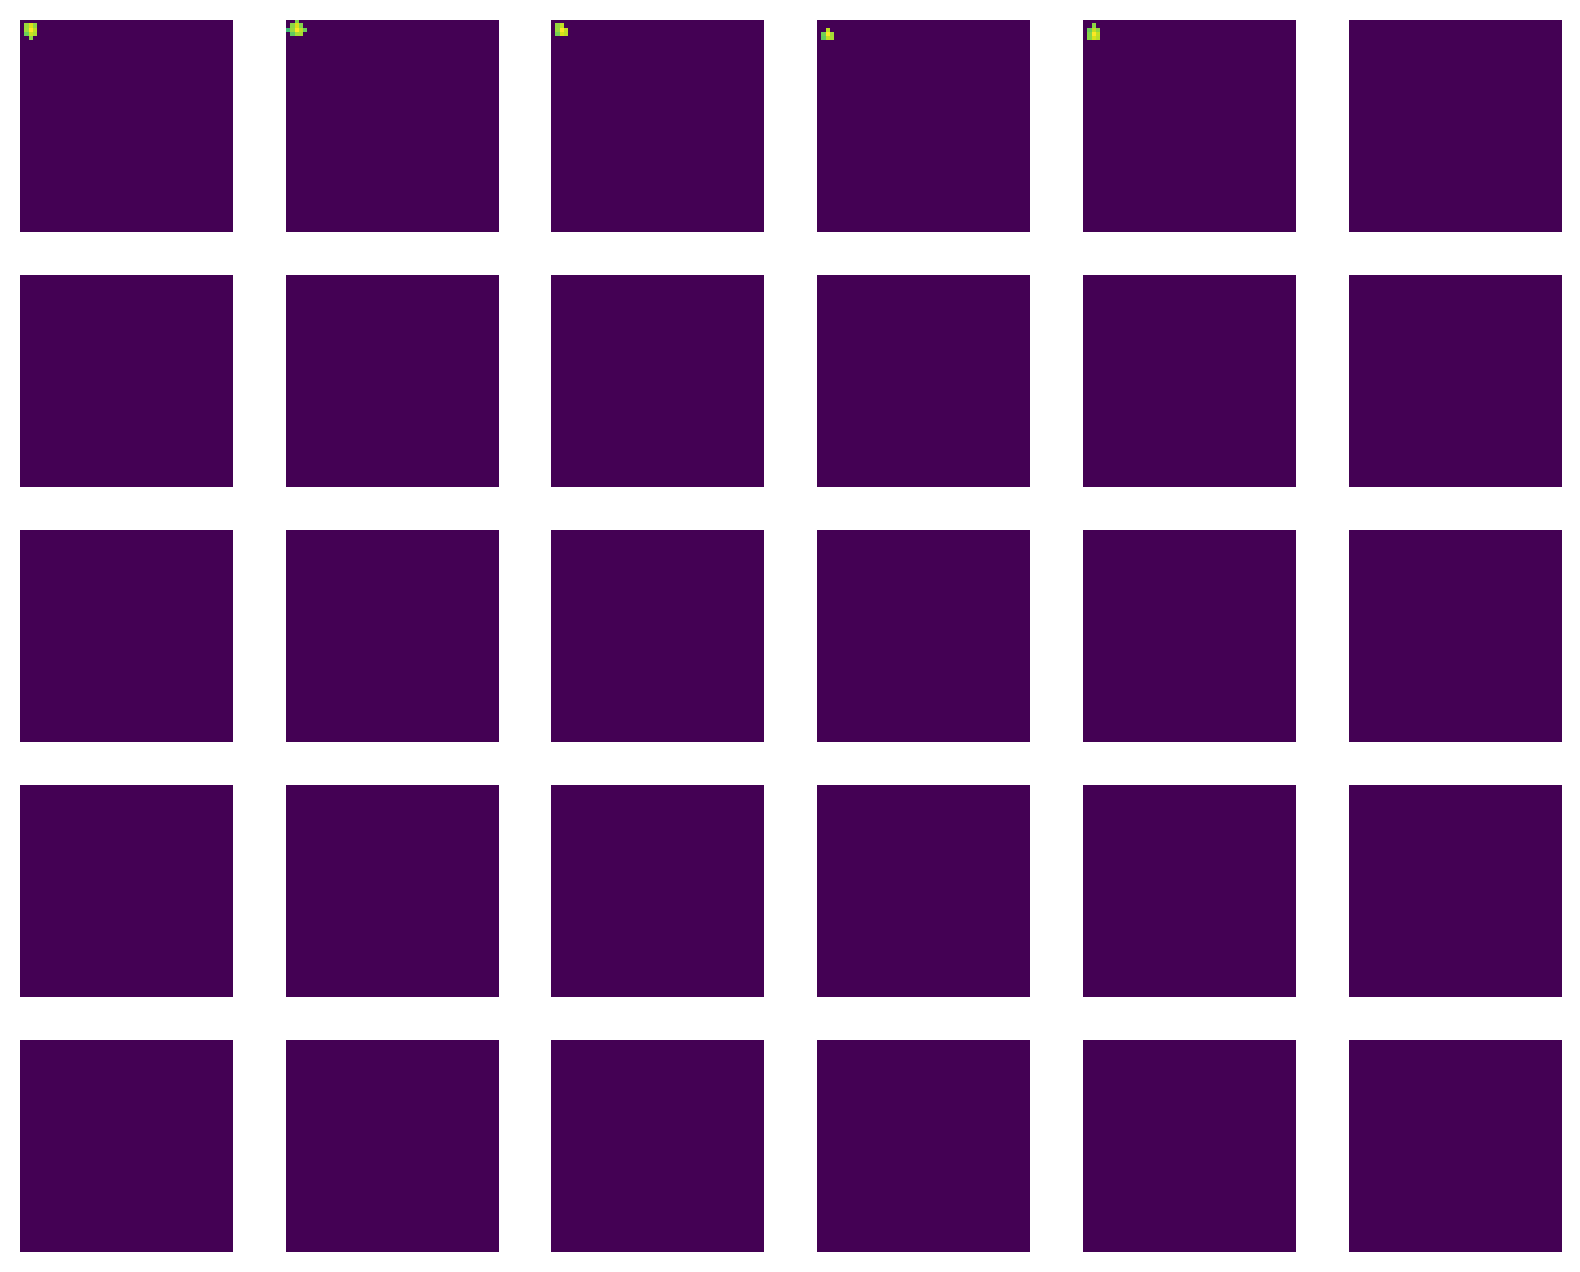

In [ ]:
indx=3
display_image(data_4_stats[indx][0].squeeze(), num_img=30)
print(f"Location:{data_4_stats[indx][2]}")

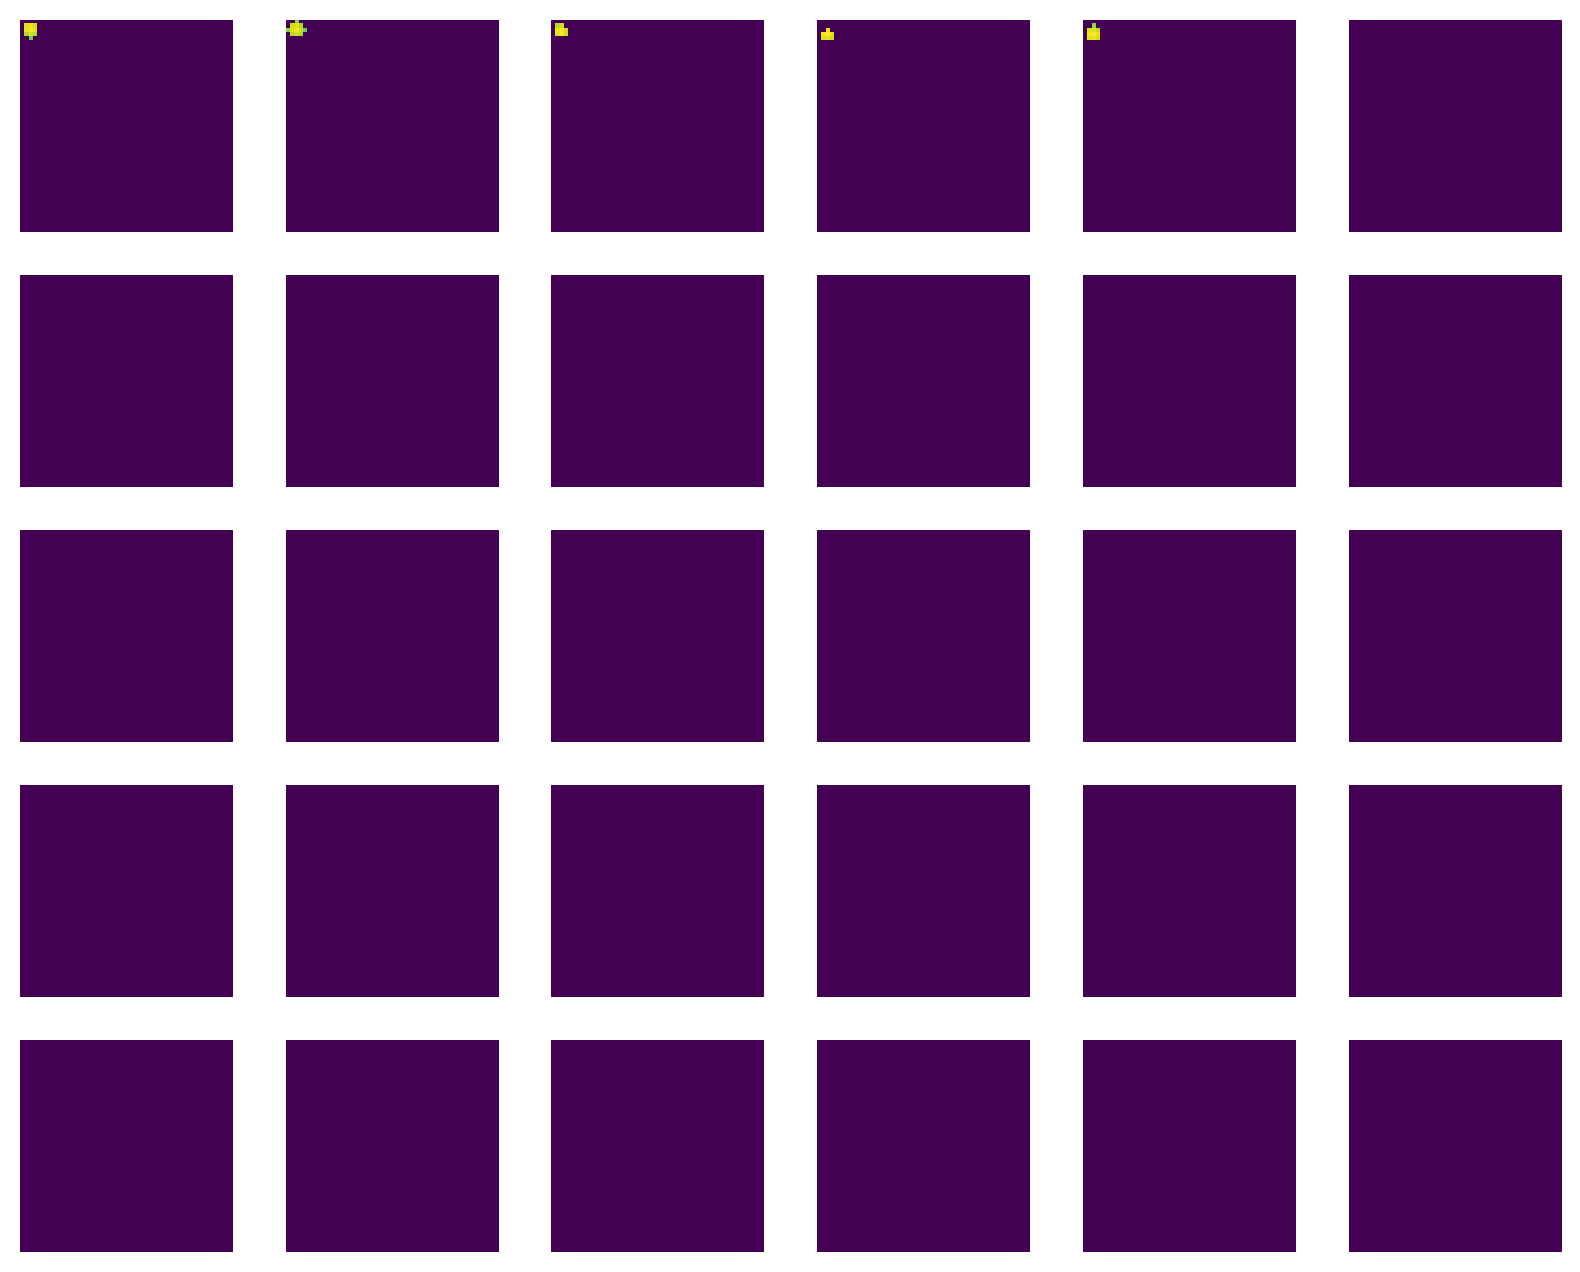

In [ ]:
display_image(data_4_stats[indx][1].squeeze(), num_img=30)

In [ ]:
#get the min and max pixels for each image in the training datasset
pixel_values_range = [(each_mri.max(), each_mri.min()) for each_mri,_,_,_,_ in  data_4_stats]

In [ ]:
pixel_values_range_max = [each[0].item() for each in pixel_values_range]
pixel_values_range_min = [each[1].item() for each in pixel_values_range]

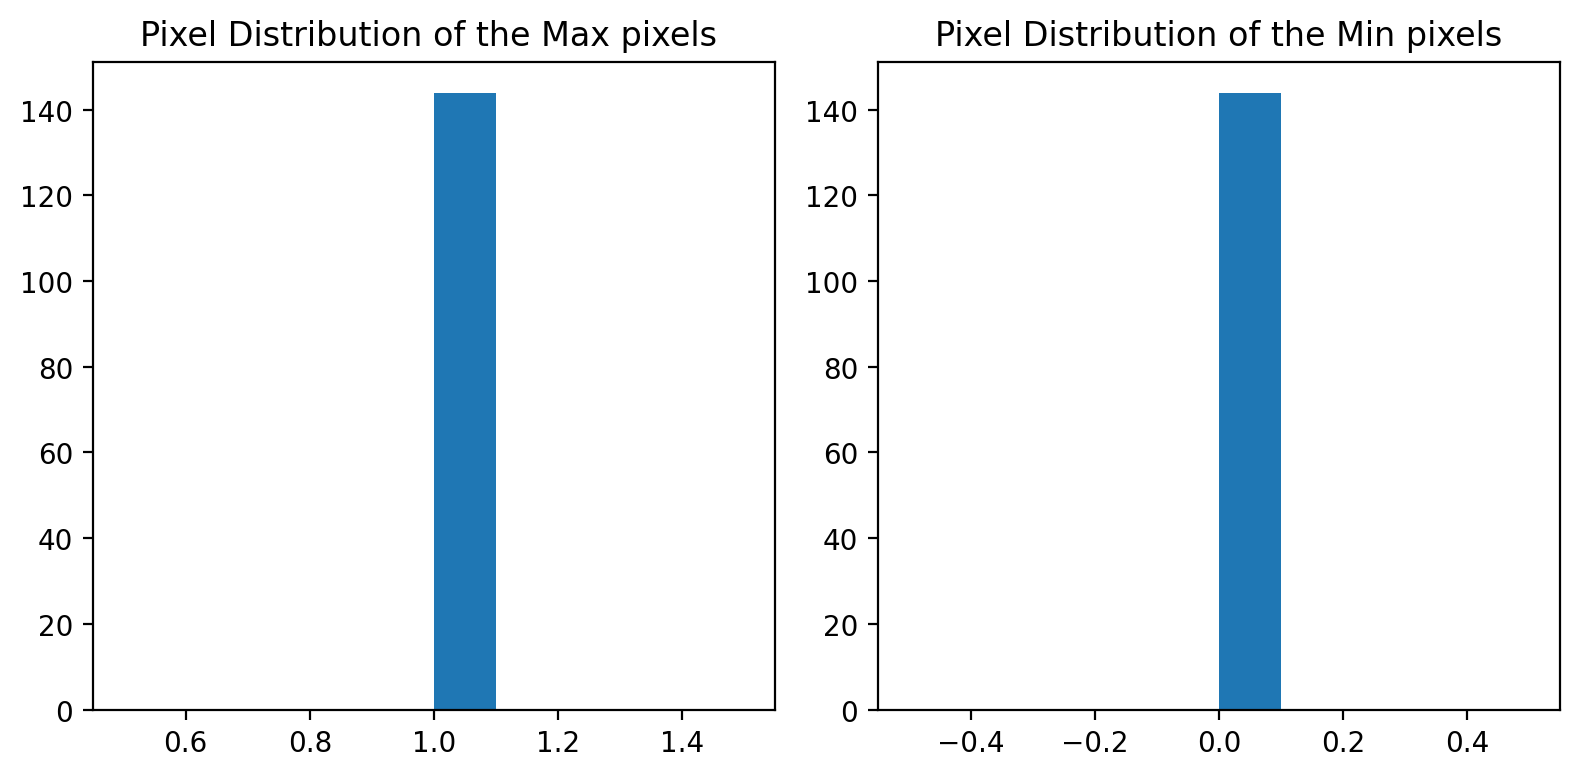

In [ ]:
#Plot the Min and Max pixel distributions
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(pixel_values_range_max )
ax[0].set_title("Pixel Distribution of the Max pixels ")

ax[1].hist(pixel_values_range_min)
ax[1].set_title("Pixel Distribution of the Min pixels")

plt.tight_layout()

From the histogram, we can see that the images have different contrast since the difference in the min and max pixel
intensity largely varies

**we need to calculate the dataset statistics like the mean and std so we can normalize the data**

In [ ]:
#Calculate image stats
def get_image_mean_std(train_dataset):
    total = 0.0
    totalsq = 0.0
    count = 0

    for data,_, _,_,_ in train_dataset:
        count += np.prod(data.shape)
        total += data.sum()
        totalsq += (data**2).sum()

    train_mean = total/count
    train_var = (totalsq/count) - (train_mean**2)
    train_std = torch.sqrt(train_var)
    return train_mean, train_std

In [ ]:
# mean_axis= torch.mean(data_4_stats[0][0].squeeze(), dim=[0,1])
# std_axis= torch.std(data_4_stats[0][0].squeeze(), dim=[0,1])
# # mean_axis1 =np.mean(data_4_stats[0][0], axis=1)
# # mean_axis2 =np.mean(data_4_stats[0][0], axis=2)

In [ ]:
# torch.Tensor(data_4_stats[0][0].squeeze()).mean()

In [ ]:
# #print the dataset mean and std of the training
# train_mean,train_std = get_image_mean_std(data_4_stats)
# train_mean.item(),train_std.item()

In [ ]:
# from scipy.ndimage import median_filter
# def Medial_filter(img):
#     return cv2.medianBlur(img, 5)

In [ ]:
# #Define the image transformations
# train_transforms= transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Pad(padding=10),
#     transforms.Resize((55,55)),
#     transforms.CenterCrop((50,50)),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(train_mean.item(),
#                          train_std.item())
# ]
# )

In [ ]:
# test_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Pad(padding=10),
#     transforms.Resize((55,55)),
#     transforms.CenterCrop((50,50)),
#     transforms.ToTensor(),
#     transforms.Normalize(train_mean.item(),
#                          train_std.item())
# ])

##Define Augmentation##

In [ ]:
!pip install kornia

In [ ]:
from kornia.augmentation import RandomDepthicalFlip3D,RandomHorizontalFlip3D,\
                            RandomRotation3D,RandomVerticalFlip3D,RandomAffine3D,RandomEqualize3D

In [ ]:
from torch import Tensor
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self) -> None:
        super().__init__()

        self.transforms = nn.Sequential(
            RandomDepthicalFlip3D(p=0.25),
            RandomRotation3D(degrees=35),
            RandomHorizontalFlip3D(p=0.25),
            RandomAffine3D(p=0.25, degrees=45),
            #RandomEqualize3D(p=0.5),
        )

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        return x_out

**Test the Augmentation Class**

**Before Augmentation**

In [ ]:
#indx =0
data_4_stats[indx][0].max()

tensor(1.)

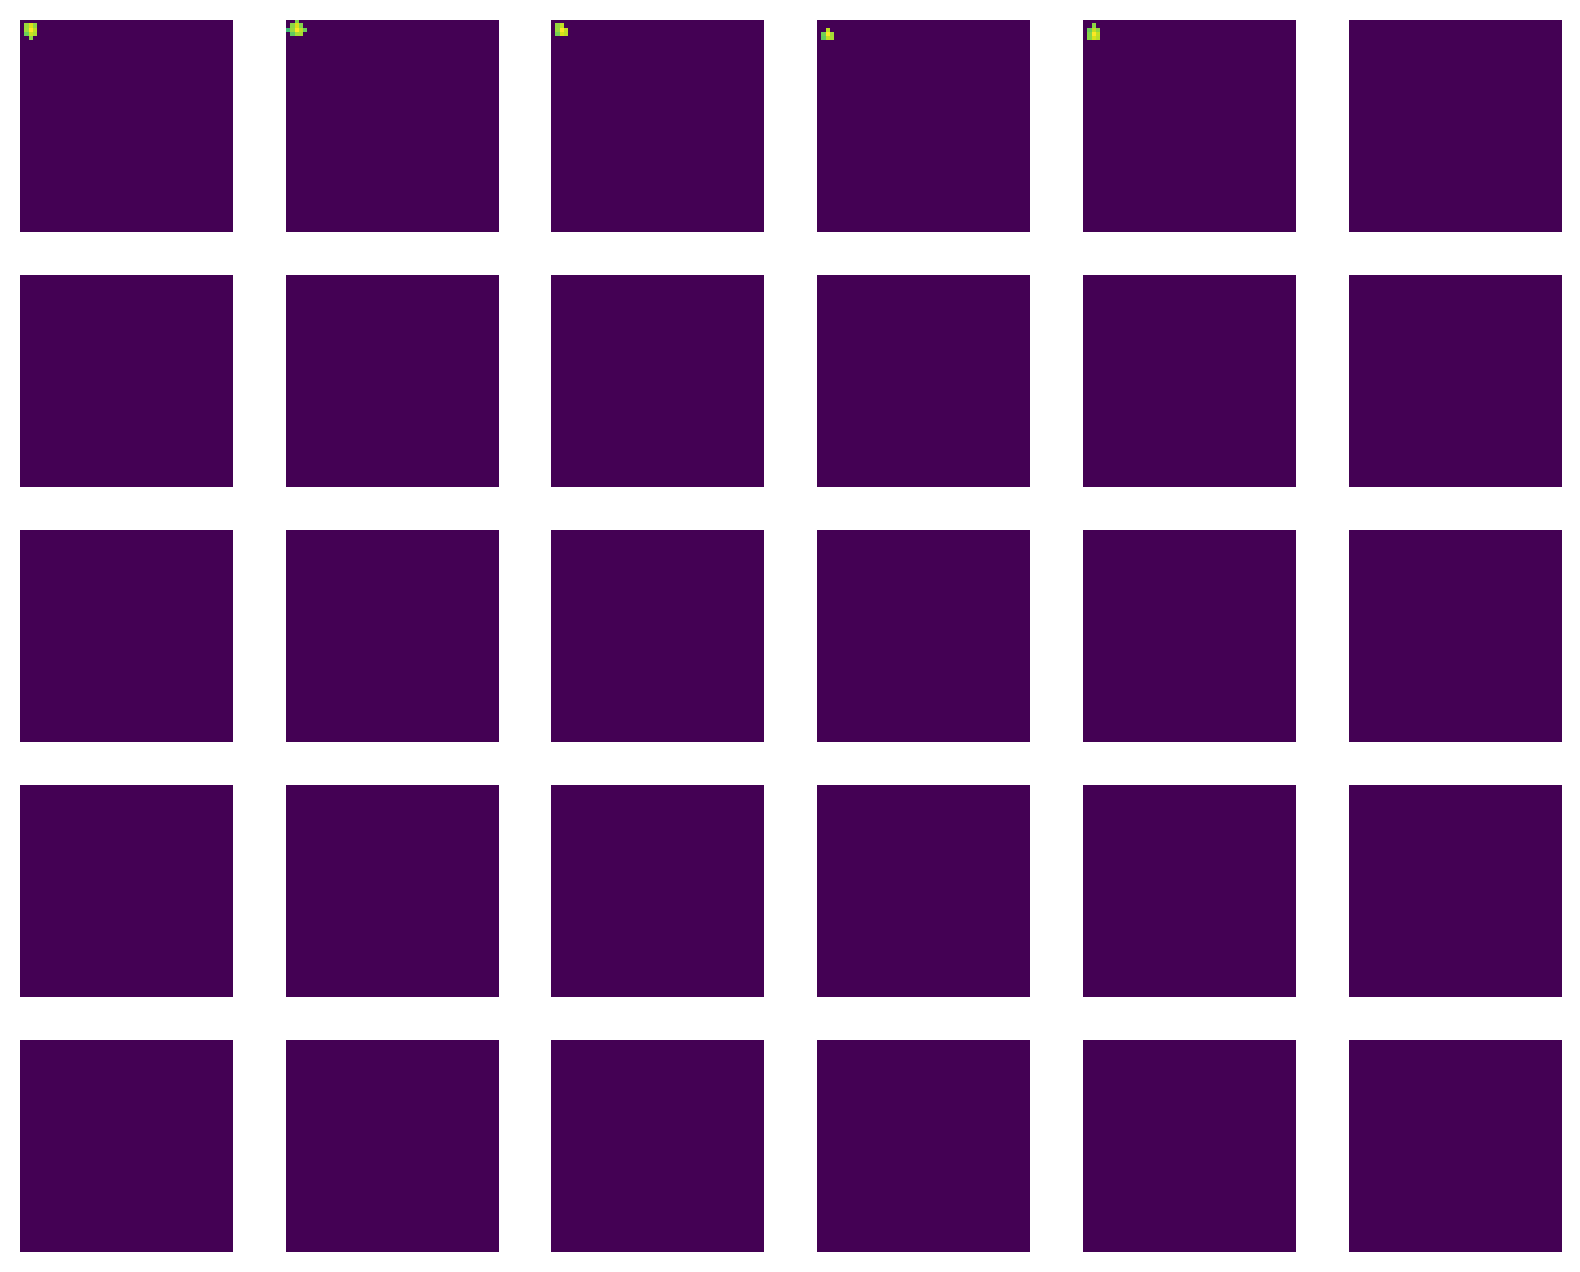

In [ ]:
display_image(data_4_stats[indx][0].squeeze(), num_img=30)

**After Augmentation**

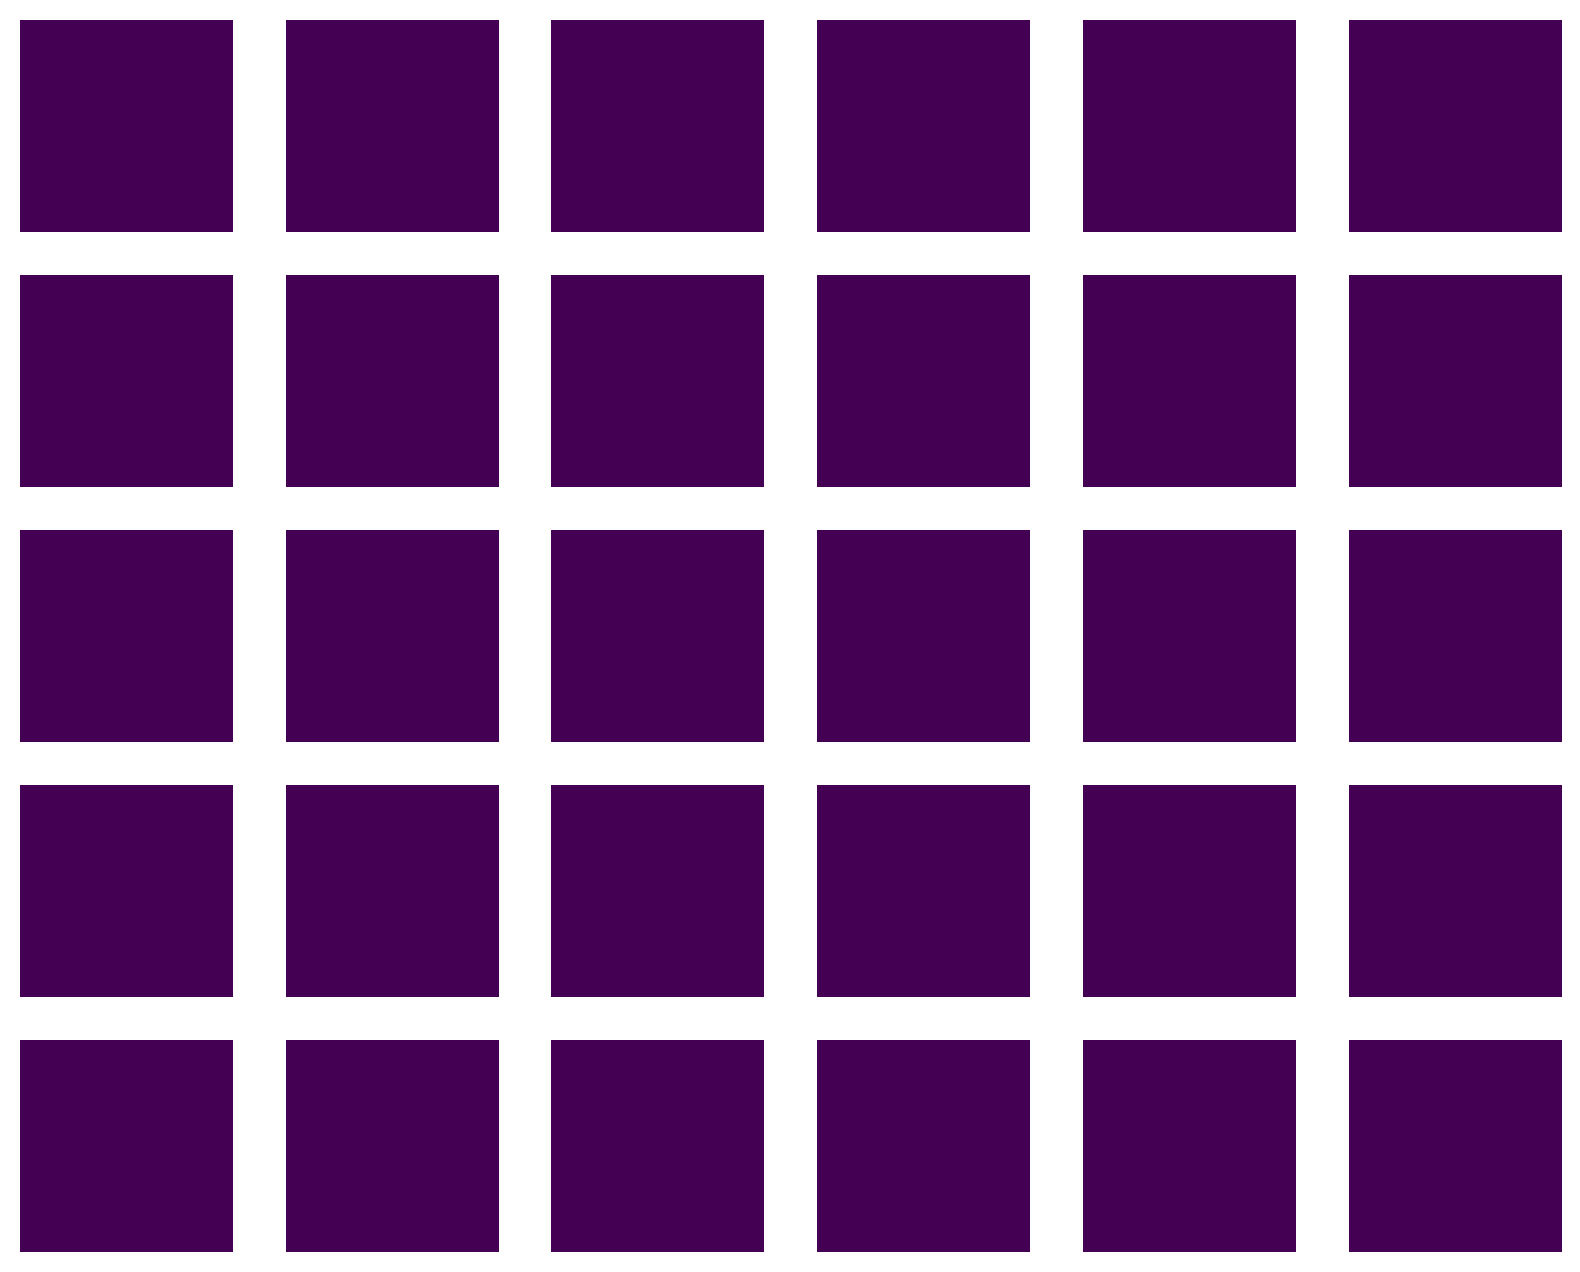

In [ ]:
aug = DataAugmentation()
out=aug(data_4_stats[indx][0])
display_image(out.squeeze(), num_img=30)

**Let's prepare the dataset for training**

In [ ]:
train_dataset = ImageFolder(df=train_data, MRI_ARR=MRI_ARR_train,
                           DOSAGE_ARR=DOSAGE_ARR_train

                                )
val_dataset = ImageFolder(df=validation_data, MRI_ARR=MRI_ARR_val,
                           DOSAGE_ARR=DOSAGE_ARR_val

                                )

test_dataset = ImageFolder(df=test_data, MRI_ARR=MRI_ARR_test,
                           DOSAGE_ARR=DOSAGE_ARR_test

                                )

***Display the new image statistics for training , validation and test dataset***

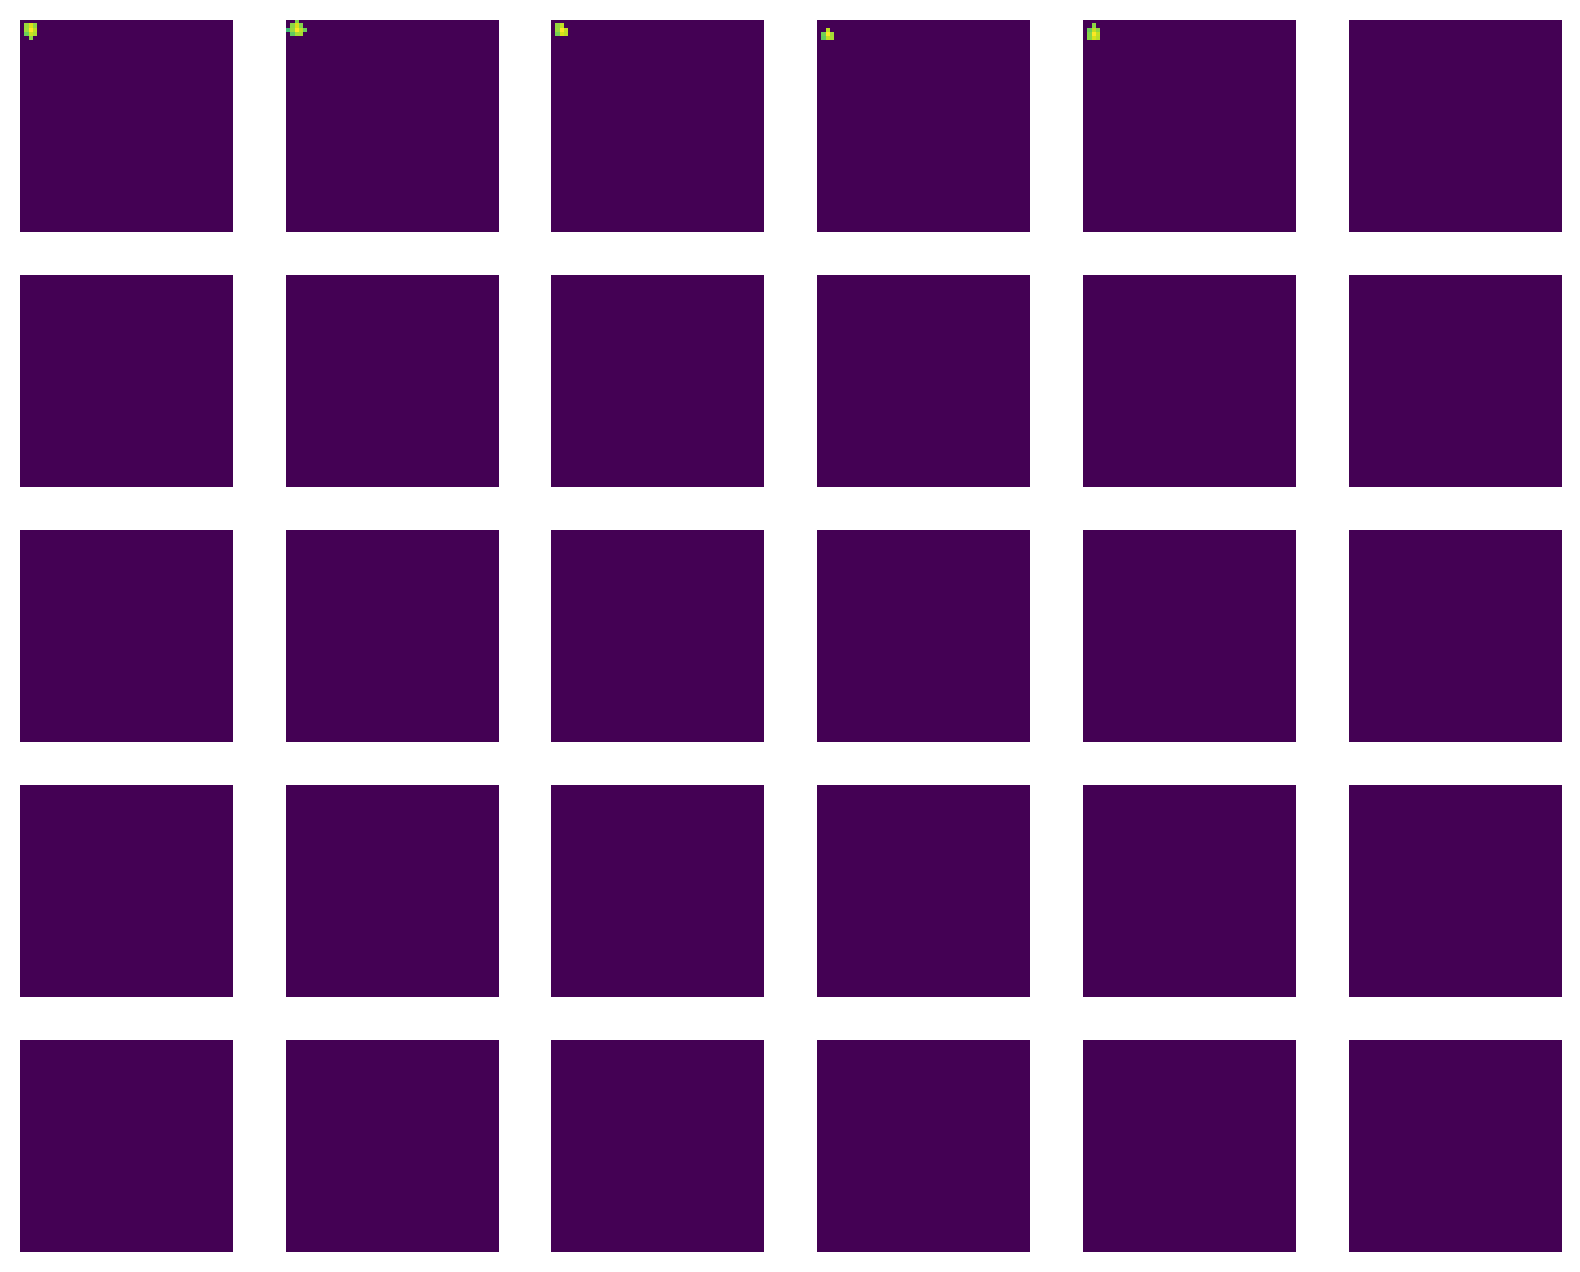

In [ ]:
display_image(train_dataset[indx][0].squeeze(),num_img=30)

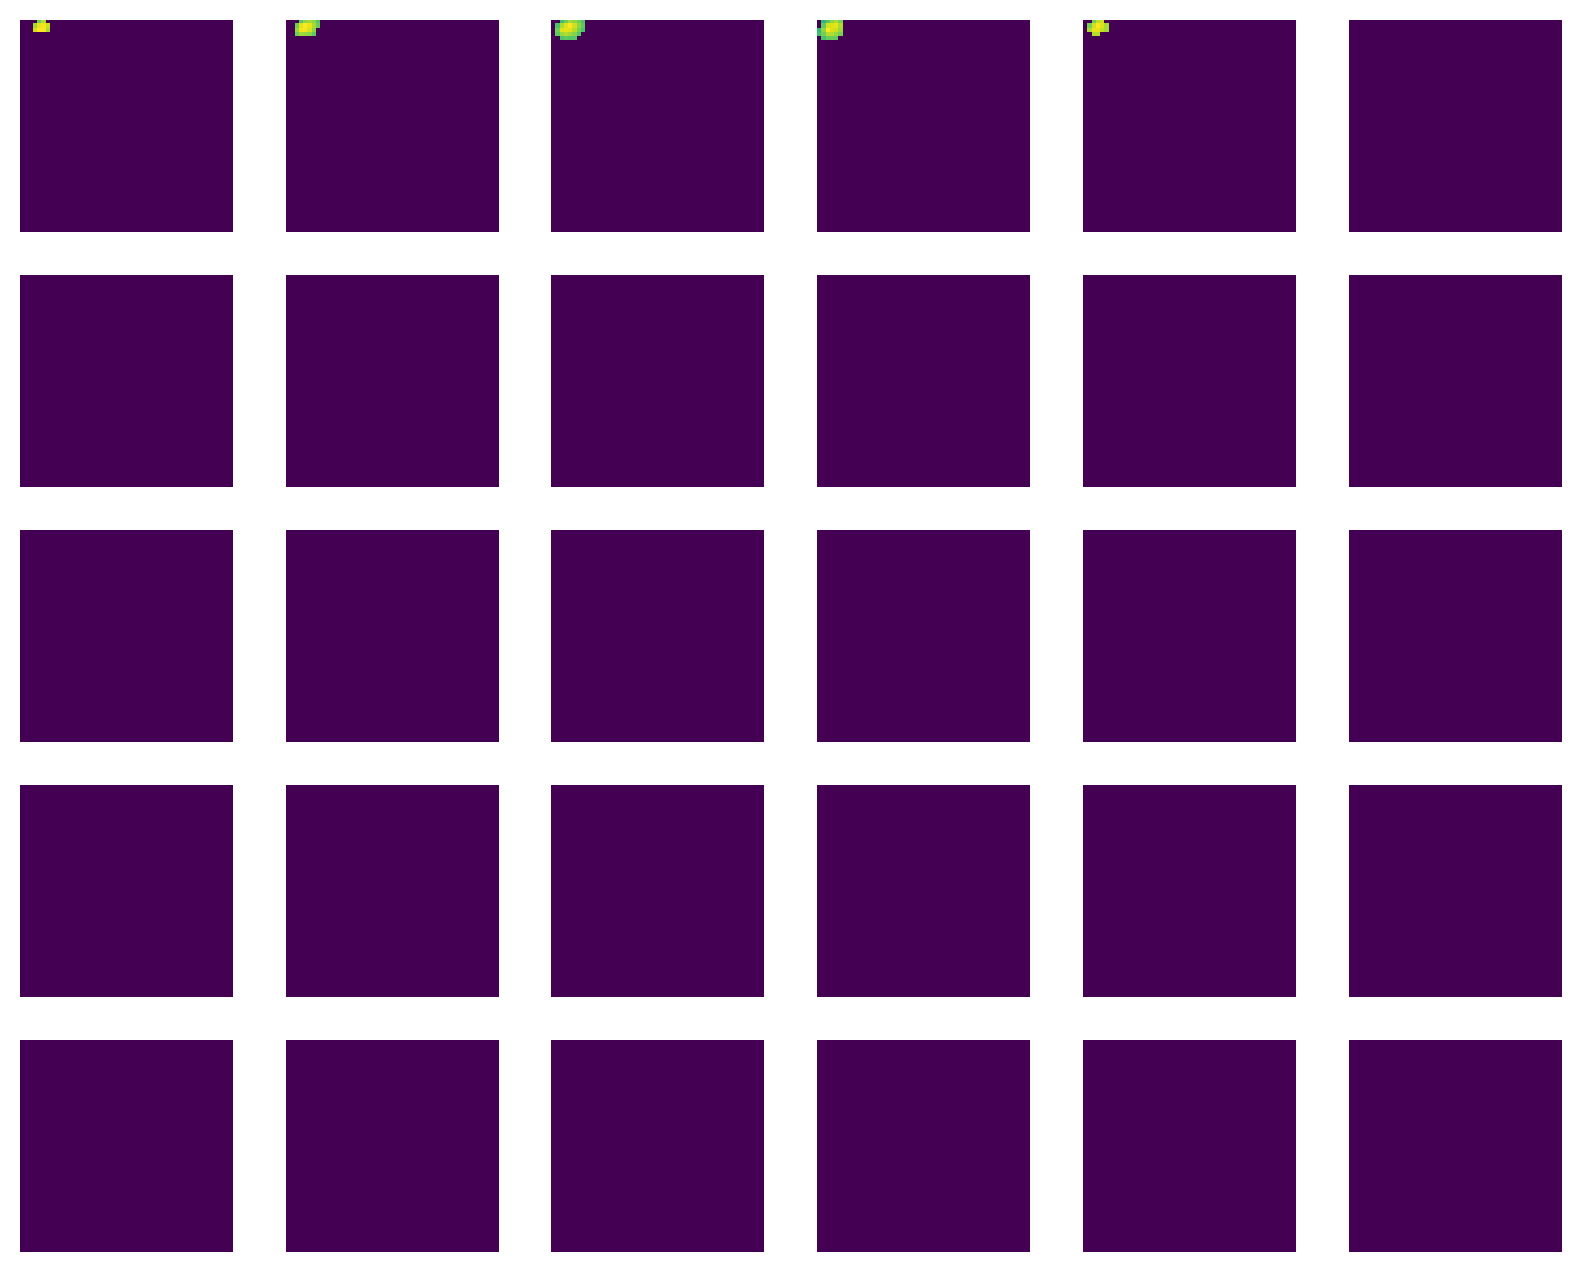

In [ ]:
display_image(val_dataset[indx][0].squeeze(),num_img=30)

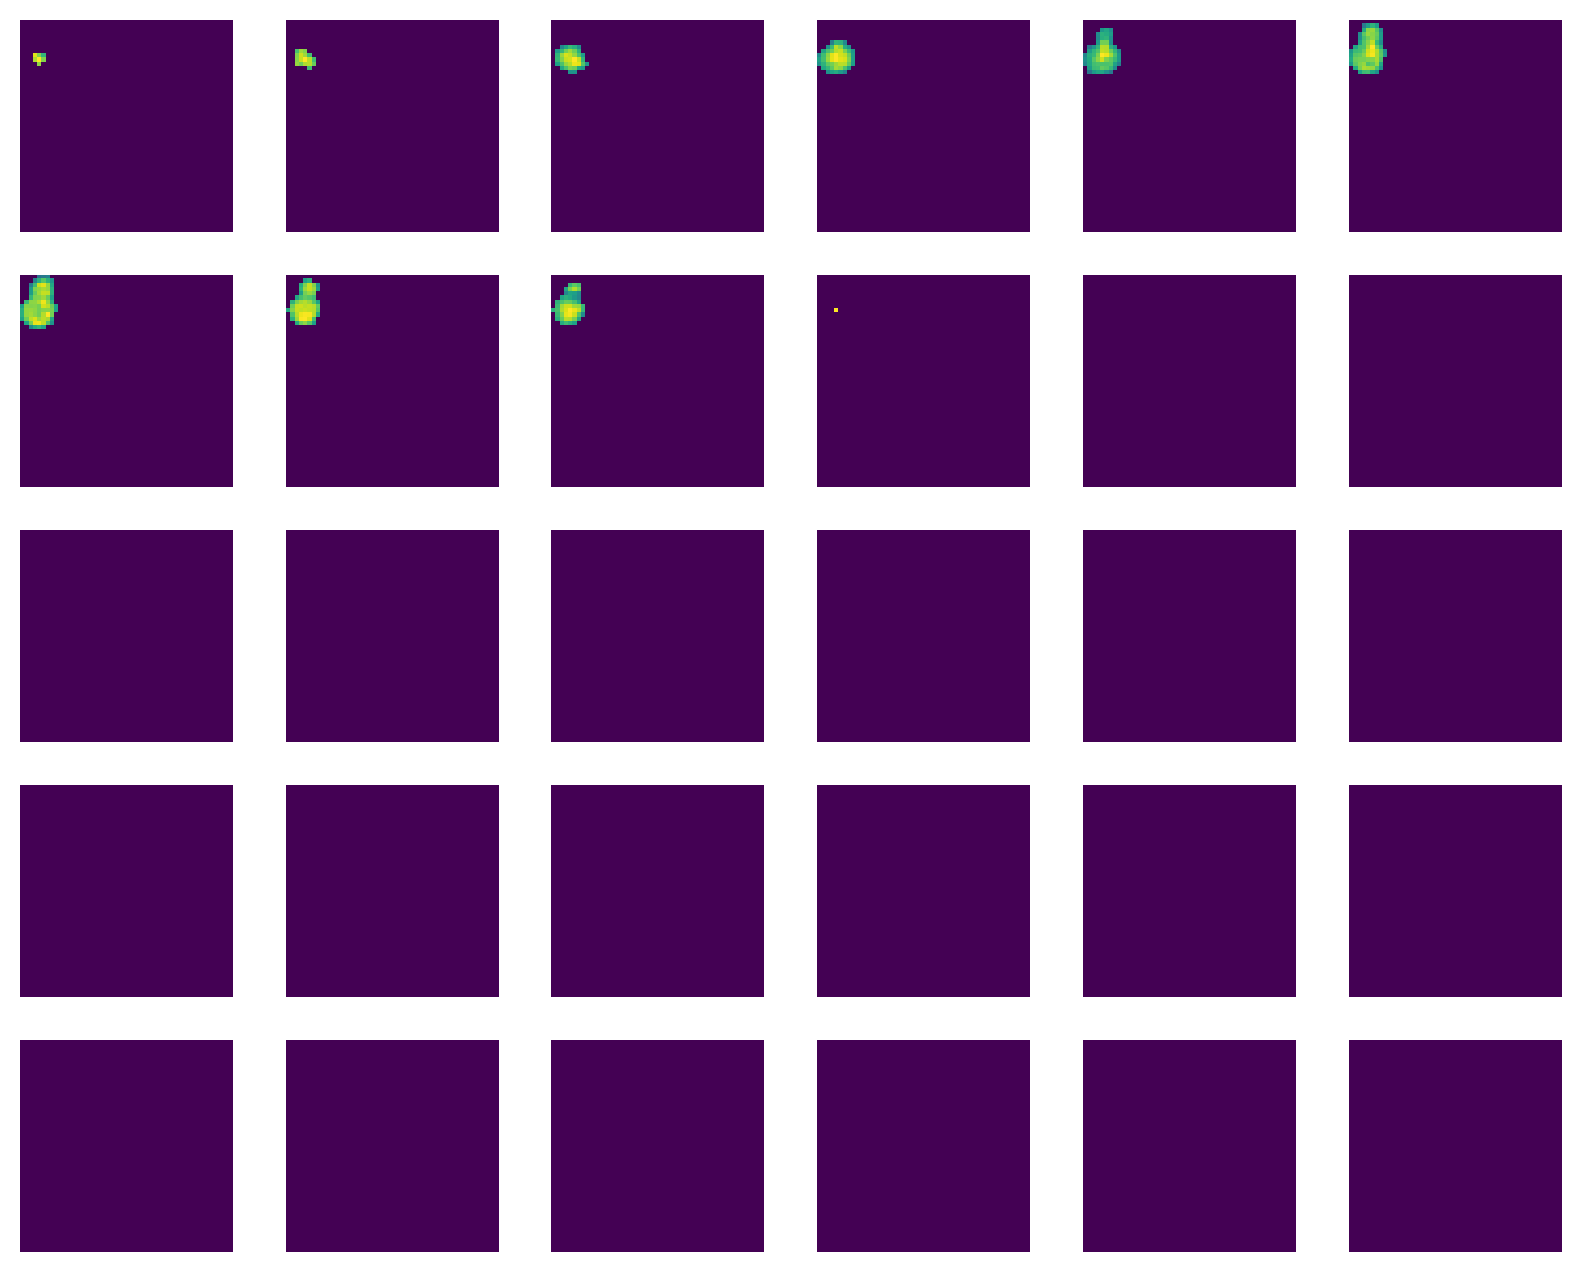

In [ ]:
display_image(test_dataset[indx][0].squeeze(),num_img=30)

In [ ]:
#create a data loader
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
#torch.manual_seed(seed)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              num_workers=2,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=32,
                            num_workers=2,
                             shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7be2aaf15f90>,
 <torch.utils.data.dataloader.DataLoader at 0x7be2aaf152a0>)

In [ ]:
mri_img,dose_img,clinical,_,label = next(iter(train_dataloader))
# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {mri_img.shape} -> [batch_size, color_channels, height, width,Depth]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 50, 50, 50]) -> [batch_size, color_channels, height, width,Depth]
Label shape: torch.Size([32])


In [ ]:
np.unique(label,return_counts=True)[1]

array([27,  5])

In [ ]:
clinical.shape

torch.Size([32, 22])

In [ ]:
# linear_layer = nn.Linear(22,128)
# linear_layer(clinical).shape
#temp = linear_layer(clinical)
#temp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).shape

In [ ]:
train_data.mri_type.map({"recurrence":1,"stable":0})

0      0
1      0
2      0
3      0
4      0
      ..
139    0
140    0
141    0
142    0
143    0
Name: mri_type, Length: 144, dtype: int64

**Uncomment for weighted sampler**

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler
def prepare_weights(targets):
    class_sample_count =np.unique(targets, return_counts=True)[1] #np.array([500,100])
    weight = 1. / torch.tensor(class_sample_count)
    samples_weight = weight[targets]
    print("prepare weight")
    return samples_weight

weights = prepare_weights(train_data.mri_type.map({"recurrence":1,"stable":0}))
sampler = WeightedRandomSampler(weights=weights,num_samples=len(weights), replacement=True,generator=torch.Generator().manual_seed(seed))

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              sampler=sampler)


prepare weight


In [ ]:
# def visualize_dataloader(dataloader, num_classes=2):

#       for batch_idx, (_,_,_,_, labels) in enumerate(dataloader):
#         # Count the occurrences of each class in the batch
#         class_counts = np.bincount(labels.numpy(), minlength=num_classes)

#         # Create a bar plot for the class distribution in the batch
#         plt.figure(figsize=(8, 5))
#         plt.bar(range(num_classes), class_counts, align='center')
#         plt.xlabel('Class')
#         plt.ylabel('Count')
#         plt.title(f'Batch {batch_idx} Class Distribution')
#         plt.xticks(range(num_classes))
#         plt.tight_layout()
#         plt.show()

In [ ]:
# visualize_dataloader(train_dataloader)

In [ ]:
 #original class distribution
 print(np.unique(train_data.mri_type,return_counts=True)[1])

[ 13 131]


In [ ]:
from collections import Counter
train_counter = Counter()
for images,_,_,_,labels in train_dataloader:
    train_counter.update(labels.tolist())
print("\n Training Label distribution:")
print(sorted(train_counter.items()))


 Training Label distribution:
[(0, 64), (1, 80)]


In [ ]:
#%pip install --quiet torch-lr-finder
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

In [ ]:
class L_Net(nn.Module):

    def __init__(self, in_channel=1,feat_dim=1024,expansion = 4,clinical_features_len=22):
        super().__init__()

        self.conv = nn.Sequential()
        #start earlier layers with small kernel size
        self.conv.add_module('conv0_s1',nn.Conv3d(in_channel, 4*expansion, kernel_size=1))
        self.conv.add_module('lrn0_s1',nn.BatchNorm3d(4*expansion))
        self.conv.add_module('relu0_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool0_s1',nn.MaxPool3d(kernel_size=3, stride=2))

        self.conv.add_module('conv1_s1',nn.Conv3d(4*expansion, 16*expansion, kernel_size=3,padding=0))
        self.conv.add_module('lrn1_s1',nn.BatchNorm3d(16*expansion))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool3d(kernel_size=3, stride=2))

        self.conv.add_module('conv2_s1',nn.Conv3d(16*expansion, 32*expansion, kernel_size=3)) #default kernel=5
        self.conv.add_module('lrn2_s1',nn.BatchNorm3d(32*expansion))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool3d(kernel_size=3, stride=2))


        self.conv.add_module('conv3_s1',nn.Conv3d(32*expansion, 32*expansion, kernel_size=3))
        self.conv.add_module('lrn2_s1',nn.BatchNorm3d(32*expansion))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool3d(kernel_size=3, stride=2)) #default kernel:5

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(96*expansion, feat_dim)) #default 5 x 5 x 5 #3*3*3
        #self.age_encoder = AgeEncoding(512,0.1,feat_dim)
        self.fc7 = nn.Linear(clinical_features_len,feat_dim)

    def forward(self, x):
        mri, dose, clinical= x[0],x[1], x[2]
        #print("CNN in")
        z = self.conv(mri)
        #print(f"MRI shape:{z.shape}")

        if x[1] is not None and x[2] is not None:
            z_dose =self.conv(dose)
            #print(f"Dose shape:{z_dose.shape}")
            z_clinical = self.fc7(clinical)
            z_clinical = z_clinical.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            #print(f"clinical shape:{z_clinical.shape}")
            z = torch.cat([z,z_dose,z_clinical],dim=1)

        elif x[1] is not None:
            z_dose =self.conv(dose)
            #print(f"Dose shape:{z_dose.shape}")
            z = torch.cat([z,z_dose],dim=1) #concatenate the rtdose

        else:
            z_clinical = self.fc7(clinical)
            z_clinical = z_clinical.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            #print(f"clinical shape:{z_clinical.shape}")
            z = torch.cat([z,z_clinical],dim=1)


        #print("CNN out")
        z = self.fc6(z.view(mri.shape[0],-1))
        #print(f"outputshape : {z.shape}")
        #print("Linear out")
        return z

In [ ]:
from torch.nn import Flatten
class Classifier(nn.Module):
    def __init__(self, in_dim, n_hid=200, n_label=2):
        super().__init__()

        self.classifier = nn.Sequential()
        self.classifier.add_module('Flatten', Flatten())
        self.classifier.add_module('Dropout', nn.Dropout(p=0.3))
        self.classifier.add_module('LinearClassifier', nn.Linear(in_dim, n_hid))

        self.classifier.add_module('Dropout', nn.Dropout(p=0.3))
        self.classifier.add_module('LinearClassifier2', nn.Linear(n_hid, n_label))
        self.initilize()

    def initilize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        return self.classifier(x)

In [ ]:
#let's define the liunet model : based on the paper "Generalizable deep learning model for early
#Alzheimer’s disease detection from structural MRIs":https://github.com/NYUMedML/CNN_design_for_AD
from torch import nn
class model_complete(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_embeddings = L_Net(in_channel=1,feat_dim=128, \
                                              expansion=4) #default 8

        self.classifier = Classifier(in_dim=128, n_hid=200, n_label=2)

    def forward(self, inputs):
        embed_inputs = self.image_embeddings(inputs)

        if self.classifier is None:
            logits = embed_inputs
        else:
            logits = self.classifier(embed_inputs)

        return logits

In [ ]:
# from model import cnn_3D
# from model import classifier

In [ ]:
#see model summary : All of the layers are trainable
#torch.manual_seed(0)
base_model= model_complete()
#model_resnet50.to(device)
summary(base_model)

Layer (type:depth-idx)                   Param #
model_complete                           --
├─L_Net: 1-1                             --
│    └─Sequential: 2-1                   --
│    │    └─Conv3d: 3-1                  32
│    │    └─BatchNorm3d: 3-2             32
│    │    └─ReLU: 3-3                    --
│    │    └─MaxPool3d: 3-4               --
│    │    └─Conv3d: 3-5                  27,712
│    │    └─BatchNorm3d: 3-6             128
│    │    └─ReLU: 3-7                    --
│    │    └─MaxPool3d: 3-8               --
│    │    └─Conv3d: 3-9                  221,312
│    │    └─BatchNorm3d: 3-10            256
│    │    └─ReLU: 3-11                   --
│    │    └─MaxPool3d: 3-12              --
│    │    └─Conv3d: 3-13                 442,496
│    │    └─ReLU: 3-14                   --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-15                 49,280
│    └─Linear: 2-3                       2,944
├─Classifier: 1-2                        --
│   

In [ ]:
from torchmetrics import AUROC,F1Score
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from kornia.losses import FocalLoss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        #print(F_loss)
        if self.alpha is not None:
            #print(targets)
            # alpha = self.alpha[targets]
            # F_loss = alpha * F_loss
            #https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/14
            alpha= (1 - self.alpha) + targets * (2 * self.alpha - 1)
            F_loss = alpha * F_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [ ]:
#check data distribution
train_counter = Counter()
for images,_,_,_,labels in train_dataloader:
    train_counter.update(labels.tolist())
print("\n Training Label distribution:")
print(sorted(train_counter.items()))

val_counter = Counter()
for images,_ ,_,_,labels in val_dataloader:
    val_counter.update(labels.tolist())
print("\n Validation Label distribution:")
print(sorted(val_counter.items()))

test_counter = Counter()
for images,_,_,_,labels in test_dataloader:
    test_counter.update(labels.tolist())
print("\n Test Label distribution:")
print(sorted(test_counter.items()))


 Training Label distribution:
[(0, 68), (1, 76)]

 Validation Label distribution:
[(0, 45), (1, 4)]

 Test Label distribution:
[(0, 40), (1, 6)]


In [ ]:
majority_class = test_counter.most_common()[0]
print(f"Majority class : {majority_class[0]}")

baseline_acc = majority_class[1]/sum(test_counter.values())
print(f"If the majority class is always predicted , the the accuracy will be :")
print(f"{baseline_acc:.2f}")

Majority class : 0
If the majority class is always predicted , the the accuracy will be :
0.87


**Check Labels distribution fed into the model each epoch**

In [ ]:
for images,_,_,_,labels in train_dataloader:
    #train_counter.update(labels.tolist())
    print(np.unique(labels,return_counts=True)[1])
#print("\n Training Label distribution:")
#print(sorted(train_counter.items()))

[16 16]
[15 17]
[12 20]
[14 18]
[ 3 13]


In [ ]:
for images,_,_,_,labels in val_dataloader:
    #train_counter.update(labels.tolist())
    print(np.unique(labels,return_counts=True)[1])
#print("\n Training Label distribution:")
#print(sorted(train_counter.items()))

[29  3]
[16  1]


In [ ]:
def compute_metrics(model, dataloader):
    criterion = CrossEntropyLoss() #FocalLoss(alpha=0.25, gamma=2.0, reduction="mean") # #
    model = model.eval()
    model = model.to(device)
    get_auc= AUROC(task="binary")
    prob=[]
    predictions_list=[]
    get_f1= F1Score(task="binary").to(device)
    for idx, (mri_features,dose_features,clinical,_,labels) in enumerate(dataloader):
        mri_features = mri_features.to(device)
        dose_features = dose_features.to(device)
        clinical = clinical.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model([mri_features,dose_features, clinical])
            #print(f"logits:{logits}")
            #print(f"logits shape:{logits.shape}")
        probabilites = F.softmax(logits,dim=1)[:,1]
        predictions = torch.argmax(logits,dim=1)
        prob.append(predictions)
        loss=criterion(logits, labels);
        #print(loss)
        #print(f"proba: {probabilites}")
        get_auc.update(probabilites,labels)
        get_f1.update(predictions,labels)
        predictions_list+=probabilites.cpu().numpy().tolist()

    return get_auc.compute(),get_f1.compute(),predictions_list

auc, f1,predictions = compute_metrics(base_model, val_dataloader)
print (f"AUC Scores : {auc.item()}")
print (f"F1 Scores : {f1.item()}")

AUC Scores : 0.6444444060325623
F1 Scores : 0.17391304671764374


In [ ]:
true_y = validation_data.mri_type.map({"stable":0,"recurrence":1}).values
true_y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0])

In [ ]:
roc_auc_score(true_y, np.array(predictions))

0.6444444444444445

In [ ]:
#https://gist.github.com/SandroLuck/a5cee19b5706a8de11fa026d4aa7d478
class Model_3D(LightningModule):
    def __init__(self,learning_rate=0.003):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model =model_complete()
        self.learning_rate=learning_rate
        self.transform = DataAugmentation()
        self.compute_loss = CrossEntropyLoss() #FocalLoss(alpha=0.15,gamma=2.0,reduction='mean') #
        self.train_auc = AUROC(task="binary")
        #self.train_f1_score = F1Score(task="binary")
        self.val_auc = AUROC(task="binary")
        #self.val_f1_score = F1Score(task="binary")
        self.test_auc = AUROC(task="binary")
        self.test_f1_score = F1Score(task="binary")
        #self.device = device
        #print("got here")

    def forward(self, x):
        return self.model(x)

    def on_after_batch_transfer(self, batch, dataloader_idx):
        mri_input,dose_input,clinical,_,label = batch
        if self.trainer.training:
            mri_input = self.transform(mri_input)  # => we perform GPU/Batched data augmentation
            dose_input = self.transform(dose_input)

        return mri_input, dose_input,clinical,label

    def _shared_step(self, batch):
        mri_features,dose_features,clinical,true_labels = batch
        #mri_features,_,true_labels= mri_features.to(device),_,true_labels.to(device)
        logits=self([mri_features,dose_features,clinical])
        #print(logits)
        #print("Got here: shared step")
        loss = self.compute_loss(logits, true_labels)
        #prob = F.softmax(logits,dim=1)
        prob = F.softmax(logits,dim=1)[:,1]
        predictions = torch.argmax(logits, dim=1)
        #print(f"prob shape:{prob.shape}")
        #prob=torch.max(prob,1)[0]
        return loss,true_labels,prob,predictions

    #https://github.com/Borda/kaggle_vol-3D-classify/blob/58185ed24f58f06c2675728a7743a46dacce5af2/kaggle_brain3d/models.py#L52
    def training_step(self, batch, batch_idx):
        #print("training step")
        loss,true_labels,proba_scores,_=self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)
        #self.log("train_f1", self.train_f1_score(proba_scores,true_labels), prog_bar=True)
        self.train_auc.update(proba_scores,true_labels)
        try:
            self.log('train_auc', self.train_auc, on_step=False, on_epoch=True)
        except ValueError:
            pass
        return loss

    # Make use of the validation set
    def validation_step(self, batch, batch_idx):
        #print("validation step")
        loss,true_labels,proba_scores,_=self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        #self.log("val_f1", self.val_f1_score(proba_scores,true_labels), prog_bar=True)
        self.val_auc.update(proba_scores,true_labels)
        try:
            self.log('val_auc', self.val_auc, on_step=False, on_epoch=True)
        except ValueError:
            pass
        return loss

    def test_step(self, batch, batch_idx):
        _,true_labels,proba_scores,pred_label=self._shared_step(batch)
        self.test_f1_score.update(proba_scores.flatten(),true_labels)
        self.log("test_f1", self.test_f1_score)
        self.test_auc.update(proba_scores,true_labels)
        try:
            self.log('test_auc', self.test_auc)
        except ValueError:
            pass

    def configure_optimizers(self):
        #print("optimizer")
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1,patience=10)
        scheduler = CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0.000005, verbose=True)
        #scheduler = CosineAnnealingWarmRestarts(optimizer, self.trainer.max_epochs, eta_min=0.000005)
        #scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
        #scheduler = MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
        return {"optimizer": optimizer, "monitor": "val_loss","lr_scheduler": scheduler}  #


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=15,mode="min")
callbacks = [ModelCheckpoint(save_top_k=1, mode ="min", monitor="val_loss", save_last=True),\
             LearningRateMonitor(logging_interval="epoch"),\
             early_stop_callback,
                TQDMProgressBar(refresh_rate=10)
            ]

In [ ]:
#seed_everything(seed)
model= Model_3D(learning_rate=0.00033)
#wandb.finish()

logger = CSVLogger(name='cnn_3d',save_dir='model_3d')

#Start the Trainer
trainer = Trainer(
    callbacks=callbacks,
    max_epochs=150,
    accelerator="gpu",
    log_every_n_steps=3,
    devices=1,
    logger=logger,
    #overfit_batches=1,
    deterministic=False,

)

#trainer = Trainer(overfit_batches=1, max_epochs=150, accelerator="cpu",callbacks=callbacks,logger=logger,log_every_n_steps=1)
# #Train the Model
trainer.fit(model, train_dataloaders= train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | model_complete   | 770 K 
1 | transform     | DataAugmentation | 0     
2 | compute_loss  | CrossEntropyLoss | 0     
3 | train_auc     | BinaryAUROC      | 0     
4 | val_auc       | BinaryAUROC      | 0     
5 | test_auc      | BinaryAUROC   

Adjusting learning rate of group 0 to 3.3000e-04.


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2996e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2986e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2968e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2943e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2911e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2872e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2826e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2772e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2712e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2645e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2571e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2489e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2401e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2306e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2205e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2096e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1981e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1859e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1730e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1595e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1453e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1305e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1151e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0990e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0823e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0650e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0470e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0285e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0094e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.9897e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.9694e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.9485e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.9271e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.9051e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8826e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8596e-04.


Validation: 0it [00:00, ?it/s]

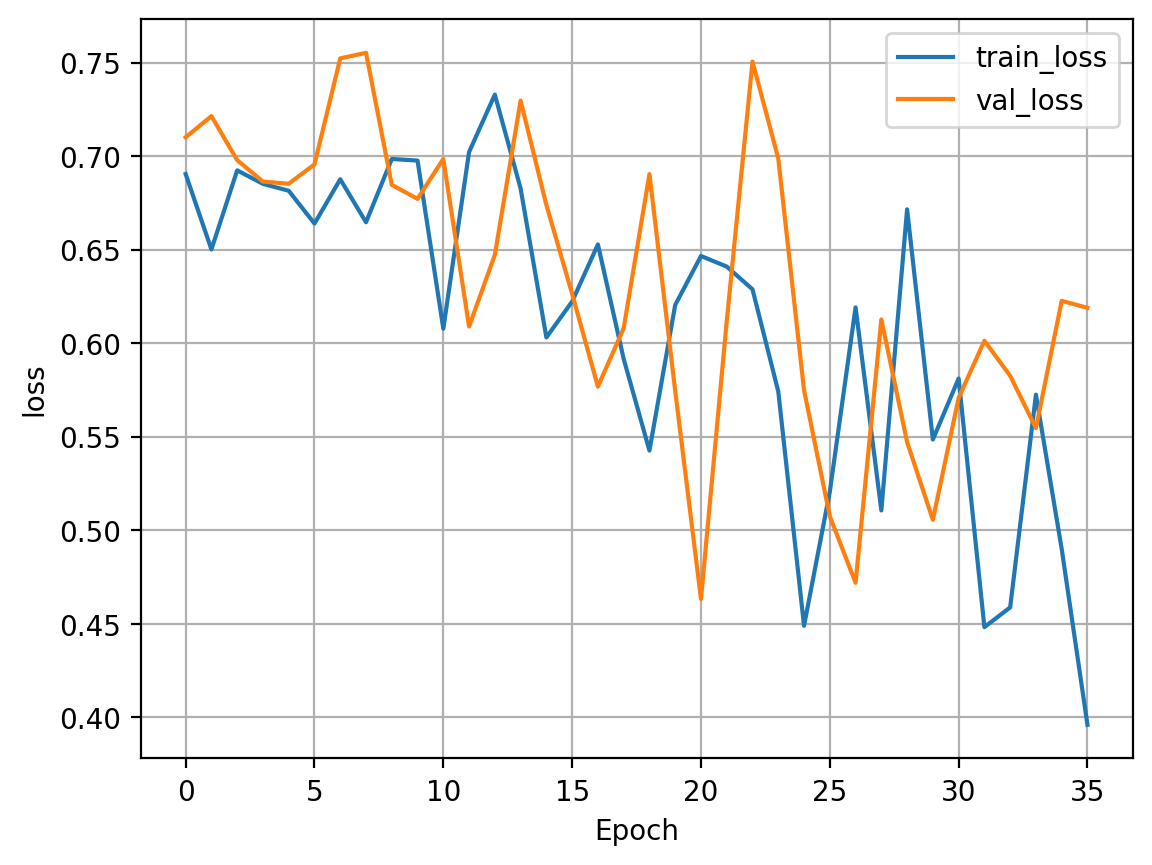

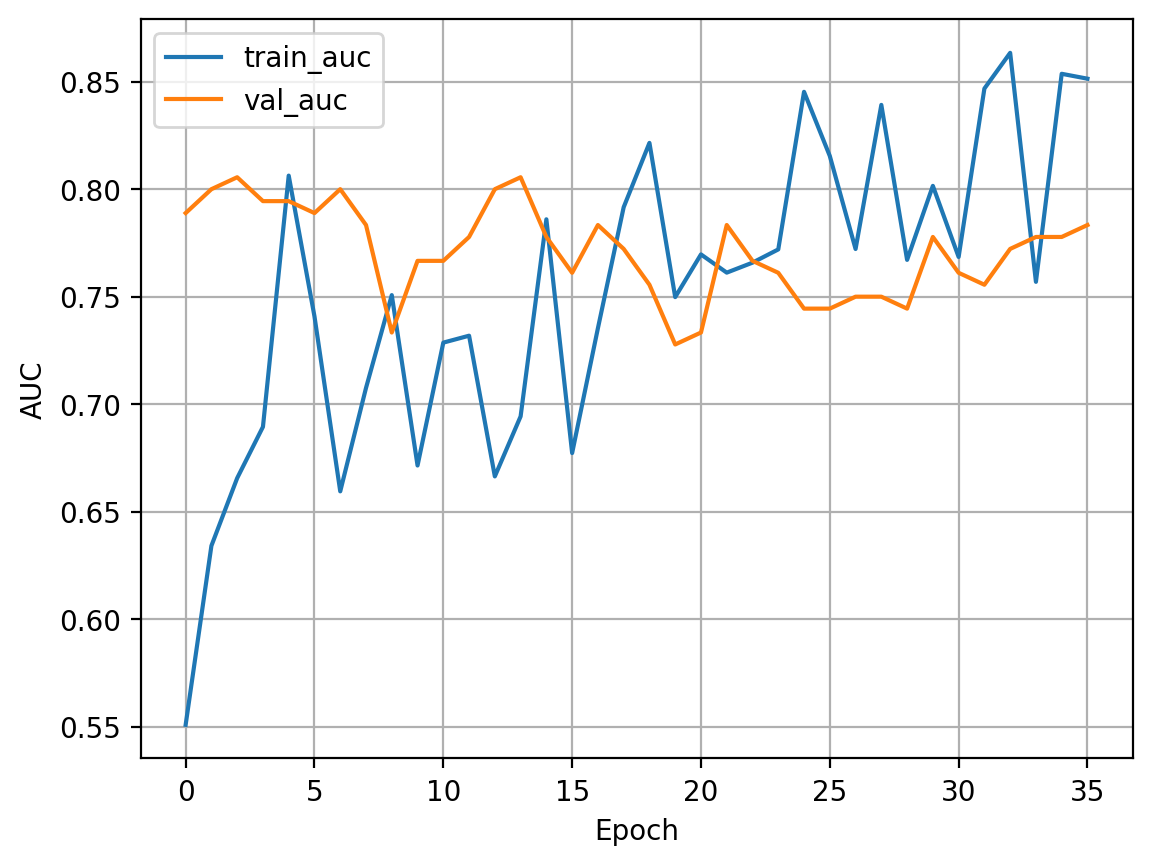

In [ ]:
#Plot results

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
aggreg_metrics =[]
agg_col = "epoch"

for i, dfg in metrics.groupby(agg_col):
    agg=dict(dfg.mean())
    agg[agg_col]=i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss","val_loss"]].plot(grid=True,legend=True, xlabel="Epoch",ylabel="loss")
df_metrics[["train_auc","val_auc"]].plot(grid=True,legend=True, xlabel="Epoch",ylabel="AUC")
plt.show()

**Training Performance**

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=False)

trainer.test(dataloaders=train_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7997651100158691     │
│          test_f1          │    0.3529411852359772     │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.3529411852359772, 'test_auc': 0.7997651100158691}]

**Validation Performance**

In [ ]:
trainer.test(model=model,dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7333333492279053     │
│          test_f1          │           0.375           │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.375, 'test_auc': 0.7333333492279053}]

**Test Performance**

In [ ]:
trainer.test(dataloaders=test_dataloader)

INFO: Restoring states from the checkpoint path at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.7791666984558105     │
│          test_f1          │    0.30000001192092896    │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.30000001192092896, 'test_auc': 0.7791666984558105}]

**Loading Model Weights**

In [ ]:
new_model = model.load_from_checkpoint(checkpoint_path="/content/model_3d/cnn_3d/version_3/checkpoints/epoch=20-step=105.ckpt")

In [ ]:
def make_predictions(model,data_Loader):
    true_labels = []
    pred_prob=[]

    model.eval()
    #with torch.no_grad():
    with torch.inference_mode():
        for i, (mri_features,dose_features,clinical_features,_,labels) in enumerate(data_Loader):
            mri_features,labels= mri_features.to(device), labels.to(device)
            dose_features,clinical_features = dose_features.to(device),clinical_features.to(device)
            logits = model([mri_features,dose_features,clinical_features])
            prob= F.softmax(logits, dim=1)[:,1]
            true_labels+=labels.detach().cpu().tolist()
            pred_prob +=prob.tolist()

    #print(f"Model AUC Scores on test set {roc_auc_score(np.array(true_labels), np.array(pred_prob))}")

    #wandb.log({"test_accuracy":correct/total_images})
    return torch.tensor(pred_prob)

In [ ]:
test_prob = make_predictions(new_model, test_dataloader)
test_pred =(test_prob>0.5).type(torch.int)

In [ ]:
actual = test_data.mri_type.map({"stable":0, "recurrence":1}).values

In [ ]:
confusion_matrix(actual,test_pred.numpy())

array([[29, 11],
       [ 3,  3]])

In [ ]:
print(classification_report(actual,test_pred.numpy()))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81        40
           1       0.21      0.50      0.30         6

    accuracy                           0.70        46
   macro avg       0.56      0.61      0.55        46
weighted avg       0.82      0.70      0.74        46



In [ ]:
roc_auc_score(actual,test_prob.numpy())

0.7791666666666667

In [ ]:
features = []

model.eval()
with torch.inference_mode():
  for mri,dose,clinical,_,label in train_dataloader:
    mri = mri.to(device)
    dose = dose.to(device)
    clinical=clinical.to(device)
    features.append(new_model.model.image_embeddings([mri,dose,clinical]).detach().cpu().numpy())

In [ ]:
np.concatenate(features, axis=0).shape

(144, 128)

In [ ]:
#np.save("features.npy",np.concatenate(features, axis=0))

In [ ]:
# Visualizing embeddings
from sklearn.manifold import TSNE
import plotly.express as px
try:
  from umap import UMAP
except:
  !pip install umap-learn
  from umap import UMAP
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [ ]:
len(train_data.mri_type.values)

144

In [ ]:
features = np.concatenate(features, axis=0)

In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler
scaling =   MinMaxScaler()
scaled_features = scaling.fit_transform(features)

In [ ]:
umap_ = UMAP(n_neighbors=10,n_components=2)
#tsne_ = TSNE(n_components=2,init="pca",learning_rate="auto")

proj_2d_umap= umap_.fit_transform(scaled_features)
#proj_2d_tsne= tsne_.fit_transform(scaled_features)

DL_pcs_umap = pd.DataFrame(proj_2d_umap, columns=["pc1","pc2"])
DL_pcs_umap= DL_pcs_umap.assign(label=train_data.mri_type.values)

#DL_pcs_tsne = pd.DataFrame(proj_2d_tsne, columns=["pc1","pc2"])
#DL_pcs_tsne= DL_pcs_tsne.assign(label=train_data.mri_type.values)

Text(0.5, 1.0, 'Feature Embeddings')

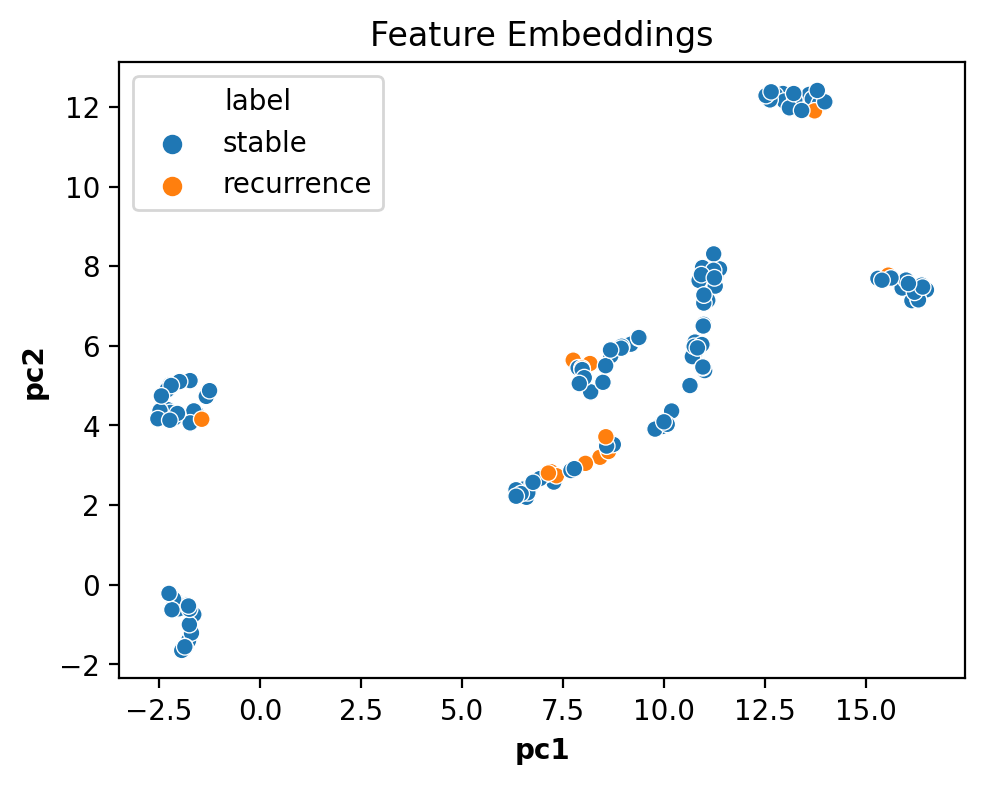

In [ ]:
#plot MRI embeddings
import seaborn as sns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax=sns.scatterplot(data=DL_pcs_umap, x="pc1", y="pc2", hue="label")
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
plt.title("Feature Embeddings")

# plt.subplot(1,2,2)
# ax=sns.scatterplot(data=DL_pcs_tsne, x="pc1", y="pc2", hue="label")
# ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
# ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
# plt.title("TSNE Embeddings")
# plt.suptitle("Plot of first two PCs for the MRI")